In [2]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools


from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *

ModuleNotFoundError: No module named 'utils'

In [3]:
def plot_cm_dist_kde(probabilities, predictions, true_labels, title): 
    true_labels = true_labels.numpy()
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    prob_tp = probabilities[true_pos, 1]
    prob_tn = probabilities[true_neg, 0]
    prob_fp = probabilities[false_pos, 1]
    prob_fn = probabilities[false_neg, 0]

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 4)
    sns.histplot(prob_tp, kde=True,color='green', bins=10)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Probability')

    plt.subplot(2, 2, 1)
    sns.histplot(prob_tn, kde=True,color='blue', bins=10)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Probability')

    plt.subplot(2, 2, 2)
    sns.histplot(prob_fp, kde=True,color='red', bins=10)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Probability')

    plt.subplot(2, 2, 3)
    sns.histplot(prob_fn, kde=True, color='orange', bins=10)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Probability')
    
    plt.tight_layout()
    plt.suptitle(f'{title}', fontsize=14, y=1.05)

    # plt.savefig(f'nek2_var_dist_tptnfpfn_kde{title}.png')

    plt.show();

In [4]:
split_path = '../../../data/NEK_data_4Berkeley/NEK2/'
# bindfile = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
# inhibfile = 'NEK2_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv'
# all_fold_df_bind= pd.read_csv(split_path+bindfile)
# all_fold_df_inhib = pd.read_csv(split_path+bindfile)
# all_fold_df_bind= look_at_data(split_path+bindfile)
# all_fold_df_inhib = look_at_data(split_path+bindfile)

In [5]:
# BalancedRandomForestClassifier
# RandomForestClassifier
# parameter: class_weight = 'balanced'
# GridSearchCV 
# before and after using balanced class weights
# training and test set performance
# plots 

In [10]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
train_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
train_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")
print(train_x_df)
train_x = torch.from_numpy(train_x_df.to_numpy())
train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
test_x = torch.from_numpy(test_x_df.to_numpy())
test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))

      ASA+_per_atom        ASA-  ASA_H_per_atom       ASA_P  ASA_per_atom  \
0         14.897949   53.326256        8.903966  161.217960     17.860519   
1          8.496225  275.100830        8.517174  278.048280     13.229856   
2          6.791036  344.713500        8.136228  261.311580     12.350931   
3          7.619170  252.392720        8.119836  235.214870     13.346833   
4          9.629118  190.869540       11.334554  127.854520     14.530917   
...             ...         ...             ...         ...           ...   
1120       7.410218  280.096590        8.489622  226.126420     13.012150   
1121       7.506570  264.718020        7.469703  267.224980     11.399482   
1122       6.830101  267.095760        9.351566   88.071762     10.592014   
1123       7.582028  226.900190        8.290327  182.277340     11.183618   
1124       7.708636  180.384670        8.409422  144.357180     11.133142   

      BCUT_PEOE_0  BCUT_PEOE_1  BCUT_PEOE_2  BCUT_PEOE_3  \
0       -2.2224

tensor([[6.5115e+00, 2.9914e+02, 8.3857e+00,  ..., 4.4950e+03, 9.4545e-01,
         3.4182e+00],
        [9.1736e+00, 1.3347e+02, 9.6770e+00,  ..., 8.2800e+02, 7.6316e-01,
         2.7368e+00],
        [8.2966e+00, 2.3739e+02, 9.7491e+00,  ..., 1.4980e+03, 1.0789e+00,
         3.5263e+00],
        ...,
        [9.2042e+00, 1.7091e+02, 1.0350e+01,  ..., 2.4830e+03, 9.6000e-01,
         3.0400e+00],
        [7.8434e+00, 1.7171e+02, 8.6059e+00,  ..., 3.0680e+03, 8.8889e-01,
         2.9630e+00],
        [8.1320e+00, 2.6826e+02, 9.8188e+00,  ..., 3.3940e+03, 1.0185e+00,
         3.4444e+00]], dtype=torch.float64)

In [7]:
# def rf_model_basic(X_train, y_train, X_test, y_test):
    # rf = RandomForestClassifier()
    # rf.fit(X_train, y_train)
    # y_pred = rf.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    # precision = precision_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    # conf_matrix = confusion_matrix(y_test, y_pred)
def rf_model(X_train, y_train, parameters): 
    n_estimators = parameters.get('n_estimators', 100)
    random_state = parameters.get('random_state', 42) 
    criterion = parameters.get('criterion', 'gini')
    max_depth = parameters.get('max_depth', 100)
    min_samples_split = parameters.get('min_samples_split', 2) 
    min_samples_leaf = parameters.get('min_samples_leaf', 1) 
    bootstrap = parameters.get('bootstrap', False) 
    max_features = parameters.get('max_features', None) 
    class_weight = parameters.get('class_weight', None)
    
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)
    rf.fit(X_train, y_train)
    return rf 
def balanced_rf(X_train, y_train, parameters): 
    n_estimators = parameters.get('n_estimators', 100)
    random_state = parameters.get('random_state', 42) 
    criterion = parameters.get('criterion', 'gini')
    max_depth = parameters.get('max_depth', 100)
    min_samples_split = parameters.get('min_samples_split', 2) 
    min_samples_leaf = parameters.get('min_samples_leaf', 1) 
    bootstrap = parameters.get('bootstrap', False) 
    max_features = parameters.get('max_features', None) 
    # class_weight = parameters.get('class_weight', None)
    balanced_rfm = BalancedRandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
    balanced_rfm.fit(X_train, y_train)
    return balanced_rfm
    


# Basic RF model

In [8]:
train_x

tensor([[1.4898e+01, 5.3326e+01, 8.9040e+00,  ..., 1.3700e+02, 8.3333e-01,
         3.2222e+00],
        [8.4962e+00, 2.7510e+02, 8.5172e+00,  ..., 3.6450e+03, 9.3220e-01,
         2.9831e+00],
        [6.7910e+00, 3.4471e+02, 8.1362e+00,  ..., 4.8470e+03, 1.0645e+00,
         3.3226e+00],
        ...,
        [6.8301e+00, 2.6710e+02, 9.3516e+00,  ..., 7.7660e+03, 1.1127e+00,
         3.4085e+00],
        [7.5820e+00, 2.2690e+02, 8.2903e+00,  ..., 4.0140e+03, 8.8889e-01,
         3.0159e+00],
        [7.7086e+00, 1.8038e+02, 8.4094e+00,  ..., 2.6280e+03, 9.6226e-01,
         3.1698e+00]], dtype=torch.float64)

train accuracy: 1.0
test accuracy: 0.911660777385159


<Axes: title={'center': 'NEK2 Binding Test'}, xlabel='Predicted label', ylabel='True label'>

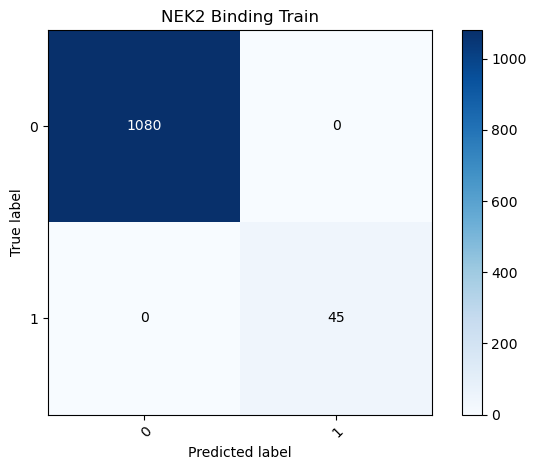

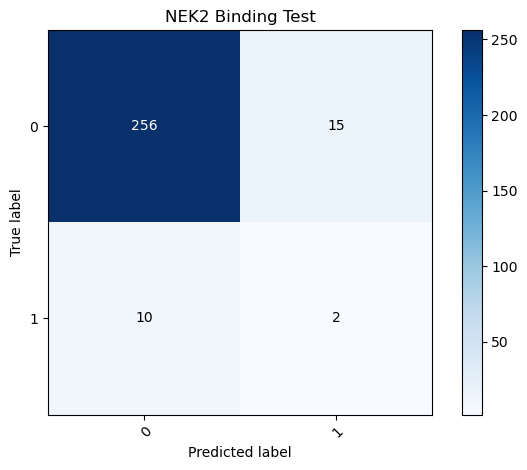

In [51]:

rf_basic = rf_model(train_x, train_y, {}) 
predictions_train = rf_basic.predict(train_x)
predictions_test = rf_basic.predict(test_x) 

acc_train = accuracy_score(train_y, predictions_train) 
acc_test = accuracy_score(test_y, predictions_test) 
print("train accuracy:", acc_train)
print("test accuracy:", acc_test)
classes = ["0", "1"]

plot_confusion_matrix(train_y.numpy(), predictions_train, classes, title="NEK2 Binding Train")
plot_confusion_matrix(test_y.numpy(), predictions_test, classes, title="NEK2 Binding Test")

# RF with class_weight: balanced 

train accuracy, balanced class weight: 1.0
test accuracy, balanced class weight: 0.9399293286219081


<Axes: title={'center': 'NEK2 Binding Test (Balanced Class Weight)'}, xlabel='Predicted label', ylabel='True label'>

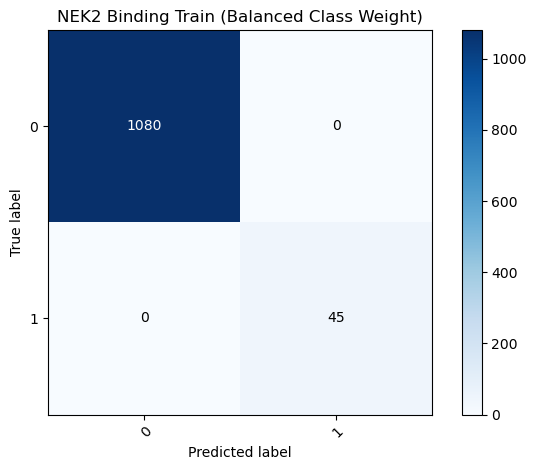

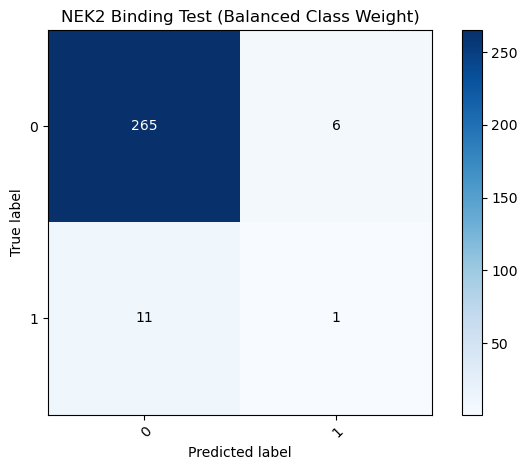

In [7]:
rf_classweightsbal = rf_model(train_x, train_y, {'class_weight': 'balanced'})
predictions_train_bal = rf_classweightsbal.predict(train_x)
predictions_test_bal = rf_classweightsbal.predict(test_x) 
acc_train_bal = accuracy_score(train_y, predictions_train_bal) 
acc_test_bal = accuracy_score(test_y, predictions_test_bal) 
print("train accuracy, balanced class weight:", acc_train_bal)
print("test accuracy, balanced class weight:", acc_test_bal)

plot_confusion_matrix(train_y.numpy(), predictions_train_bal, classes, title="NEK2 Binding Train (Balanced Class Weight)")
plot_confusion_matrix(test_y.numpy(), predictions_test_bal, classes, title="NEK2 Binding Test (Balanced Class Weight)")

# Save to pickle file and don't run again unless needed

In [11]:
# param_grid = {
#     'n_estimators': [100, 150, 200, 250,300],
#     'max_depth': [None, 10, 15, 20, 25],
#     'min_samples_split': [2, 5, 8,10,15],
#     'min_samples_leaf': [1, 2, 3,4,5],
#     'class_weight': [None, 'balanced']
# }
# rf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
# grid_search.fit(train_x, train_y)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 10, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 8, 10, 15],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [12]:
# best_estimator = grid_search.best_estimator_
# with open('best_rf_model_nek2_binding.pkl', 'wb') as f:
#     pickle.dump(best_estimator, f)

In [8]:
# read pickle file 
with open('best_rf_model_nek2_binding.pkl', 'rb') as f:
    best_estimator = pickle.load(f)
# best_estimator = grid_search.best_estimator_
best_params = best_estimator.get_params()
for param, value in best_params.items():
    print(f"{param}: {value}")

bootstrap: True
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 150
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


accuracy best model GridSearch CV:  0.9991111111111111
accuracy best model GridSearch CV:  0.9611307420494699


<Axes: title={'center': 'NEK2 Binding Test - Best Estimator'}, xlabel='Predicted label', ylabel='True label'>

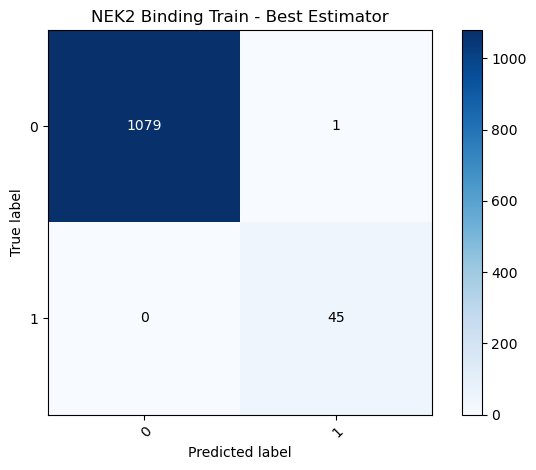

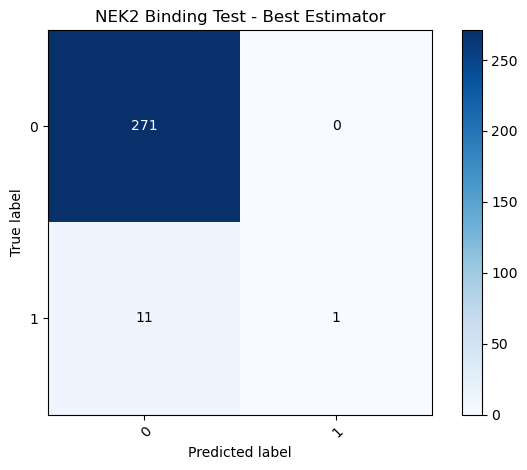

In [9]:
pred_train_best = best_estimator.predict(train_x)
acc_train_best = accuracy_score(train_y, pred_train_best) 
print('accuracy best model GridSearch CV: ',acc_train_best )
plot_confusion_matrix(train_y.numpy(), pred_train_best, classes, title="NEK2 Binding Train - Best Estimator")


pred_test_best = best_estimator.predict(test_x)
acc_test_best = accuracy_score(test_y, pred_test_best) 
print('accuracy best model GridSearch CV: ',acc_test_best)
plot_confusion_matrix(test_y.numpy(), pred_test_best, classes, title="NEK2 Binding Test - Best Estimator")

# Balanced Random Forest Classifier 

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


train accuracy: 0.752
test accuracy: 0.7420494699646644


<Axes: title={'center': 'NEK2 Binding Test - BalancedRF'}, xlabel='Predicted label', ylabel='True label'>

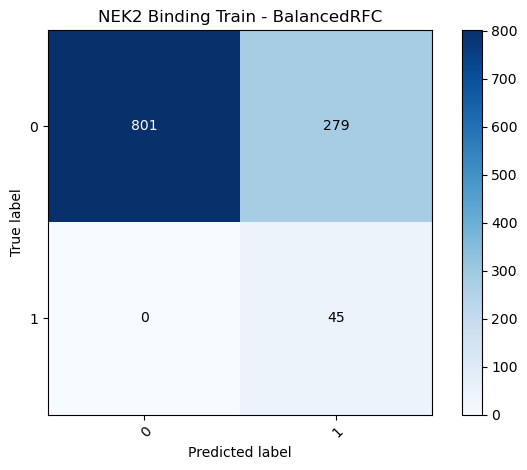

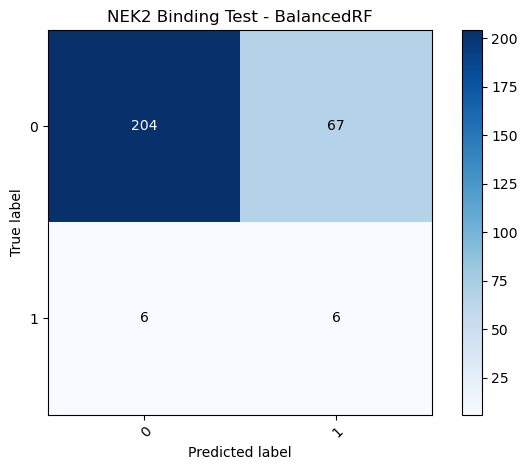

In [56]:

rf_bal = balanced_rf(train_x, train_y, {}) 
predictions_train_balrf = rf_bal.predict(train_x)
predictions_test_balrf = rf_bal.predict(test_x) 
acc_train_balrf = accuracy_score(train_y, predictions_train_balrf) 
acc_test_balrf = accuracy_score(test_y, predictions_test_balrf) 
print("train accuracy:", acc_train_balrf)
print("test accuracy:", acc_test_balrf)
classes = ["0", "1"]

plot_confusion_matrix(train_y.numpy(), predictions_train_balrf, classes, title="NEK2 Binding Train - BalancedRFC")
plot_confusion_matrix(test_y.numpy(), predictions_test_balrf, classes, title="NEK2 Binding Test - BalancedRF")

In [11]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced']
}
rf_bal = BalancedRandomForestClassifier()
grid_search2 = GridSearchCV(estimator=rf_bal, param_grid=param_grid, cv=5)
grid_search2.fit(train_x, train_y)

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

GridSearchCV(cv=5, estimator=BalancedRandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]})

In [15]:
best_params2 = best_estimator2.get_params()
for param, value in best_params2.items():
    print(f"{param}: {value}")
best_estimator2 = grid_search2.best_estimator_
with open('best_rf_bal_model_nek2_binding.pkl', 'wb') as f:
    pickle.dump(best_estimator2, f)


bootstrap: warn
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 150
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


In [16]:
# read pickle file 
# best_estimator2 = grid_search2.best_estimator_
with open('best_rf_bal_model_nek2_binding.pkl', 'rb') as f:
    best_estimator2 = pickle.load(f)
# best_estimator = grid_search.best_estimator_


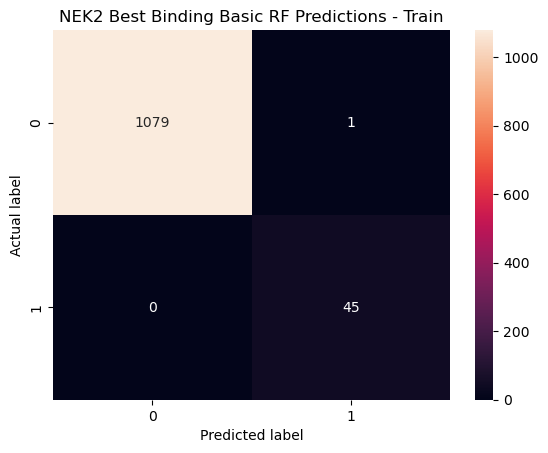

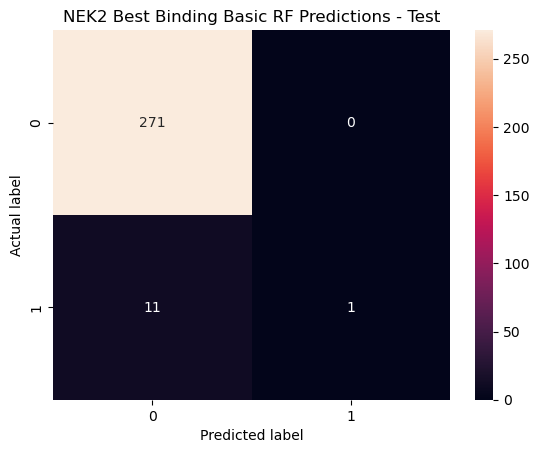

In [91]:
plot_cm_dist(train_y, pred_train_best, title="NEK2 Best Binding Basic RF Predictions - Train")
plot_cm_dist(test_y,pred_test_best, title="NEK2 Best Binding Basic RF Predictions - Test")

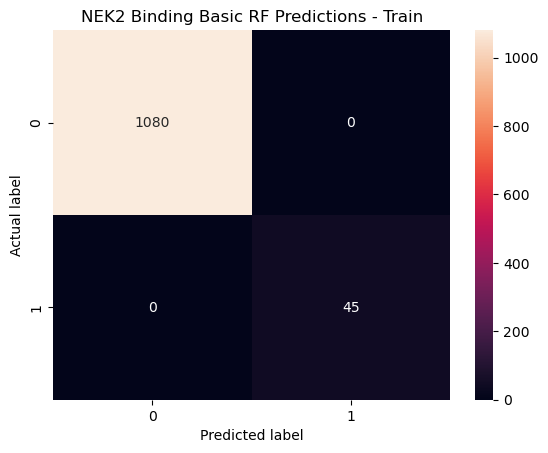

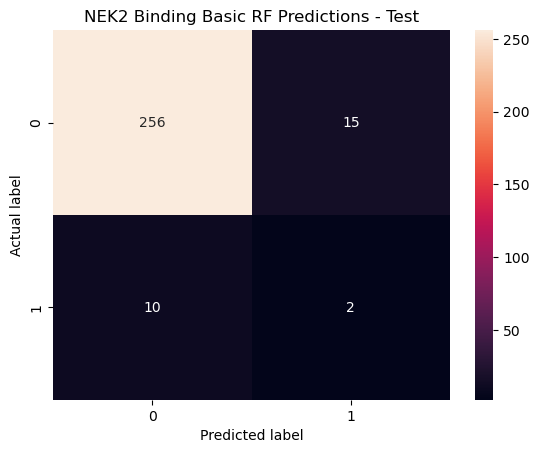

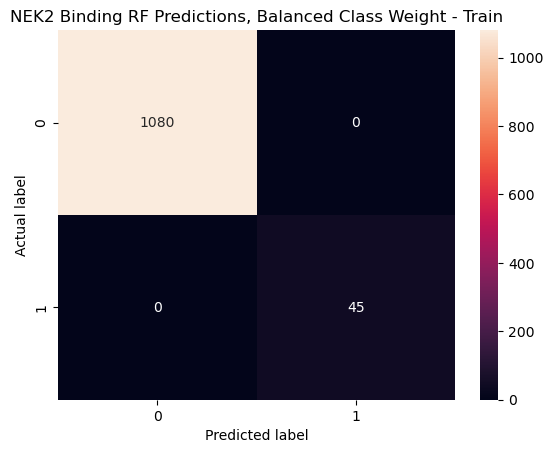

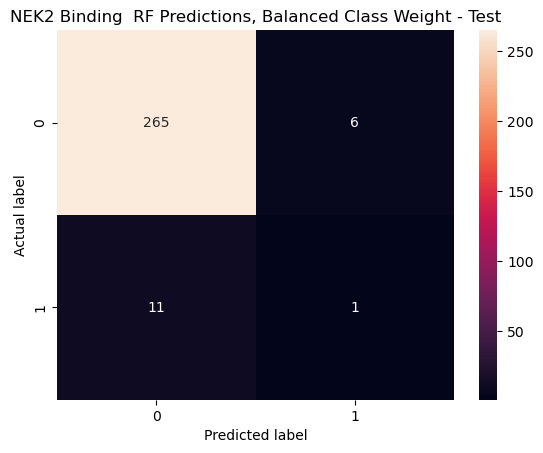

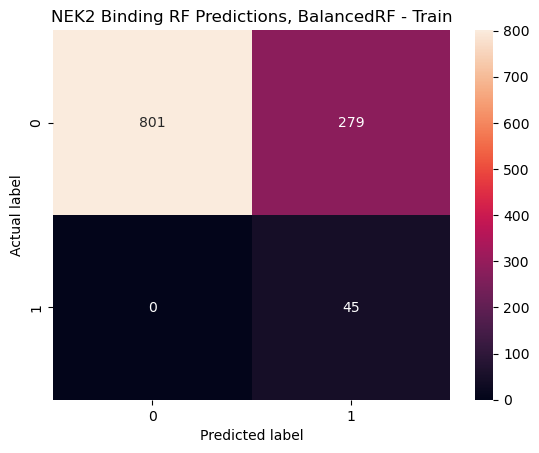

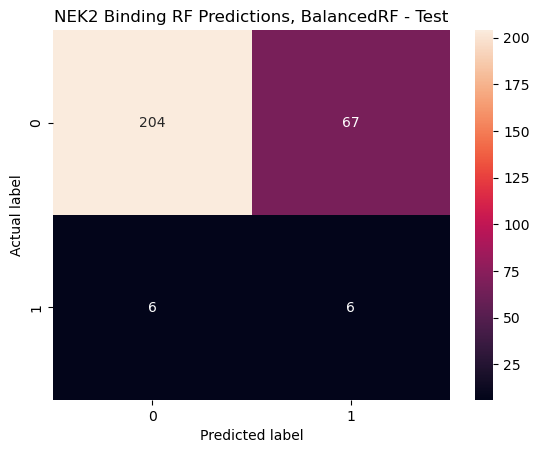

In [62]:
plot_cm_dist(train_y, predictions_train, title="NEK2 Binding Basic RF Predictions - Train")
plot_cm_dist(test_y, predictions_test, title="NEK2 Binding Basic RF Predictions - Test")

plot_cm_dist(train_y, predictions_train_bal, title="NEK2 Binding RF Predictions, Balanced Class Weight - Train")
plot_cm_dist(test_y, predictions_test_bal, title="NEK2 Binding  RF Predictions, Balanced Class Weight - Test")

plot_cm_dist(train_y, predictions_train_balrf, title="NEK2 Binding RF Predictions, BalancedRF - Train")
plot_cm_dist(test_y, predictions_test_balrf, title="NEK2 Binding RF Predictions, BalancedRF - Test")

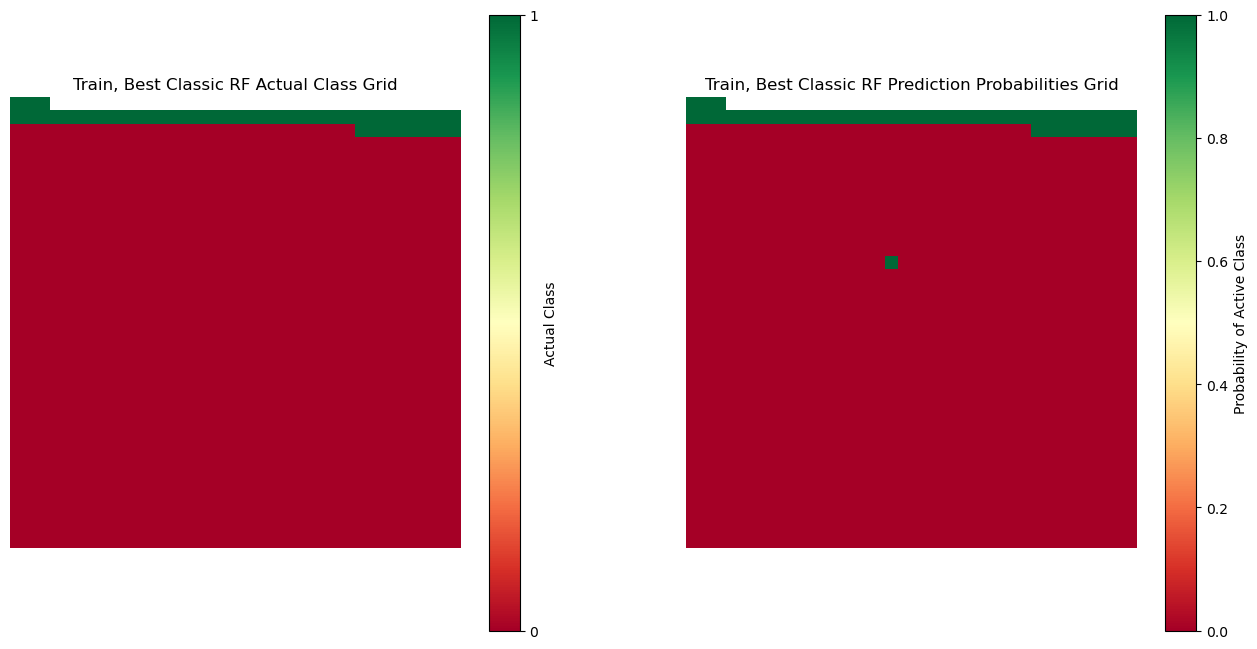

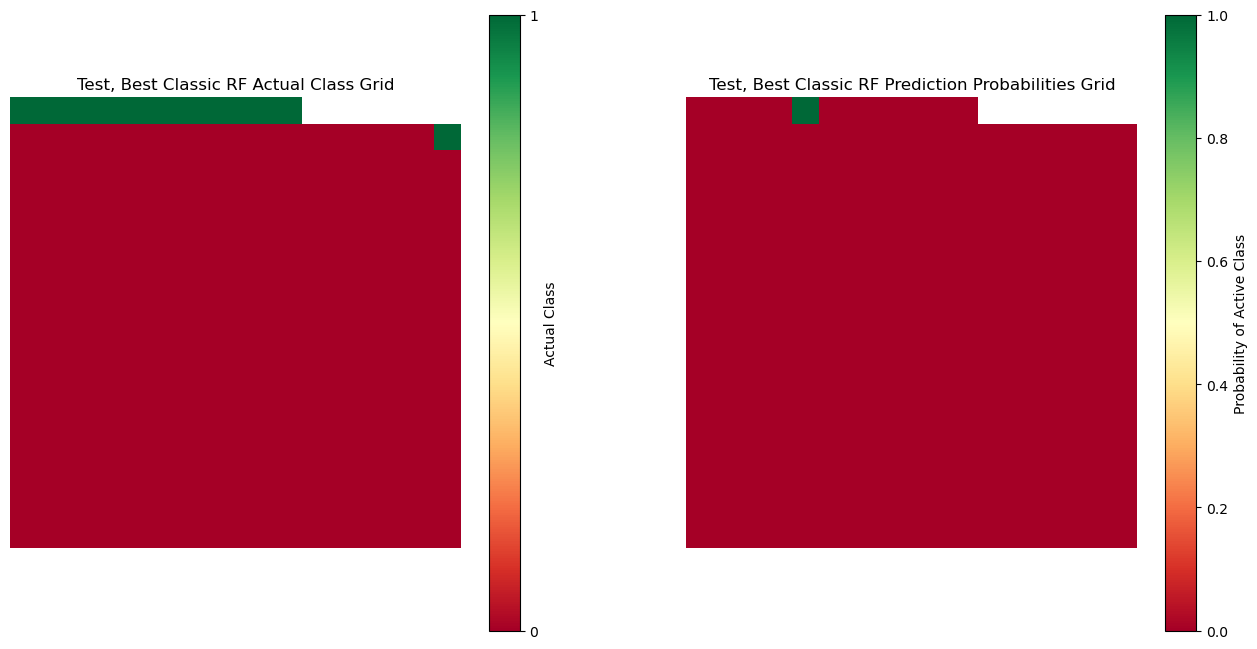

In [92]:

plot_class_and_probability_grids(train_y, pred_train_best, title_prefix='Train, Best Classic RF ') 
plot_class_and_probability_grids(test_y, pred_test_best, title_prefix='Test, Best Classic RF ') 

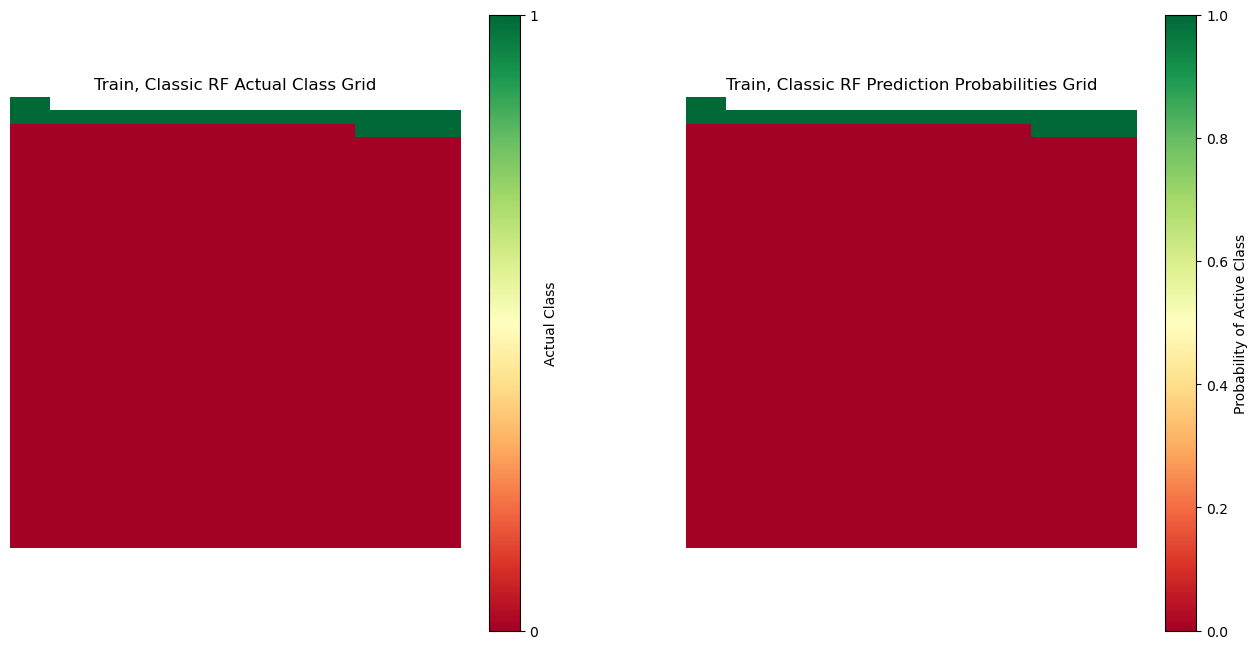

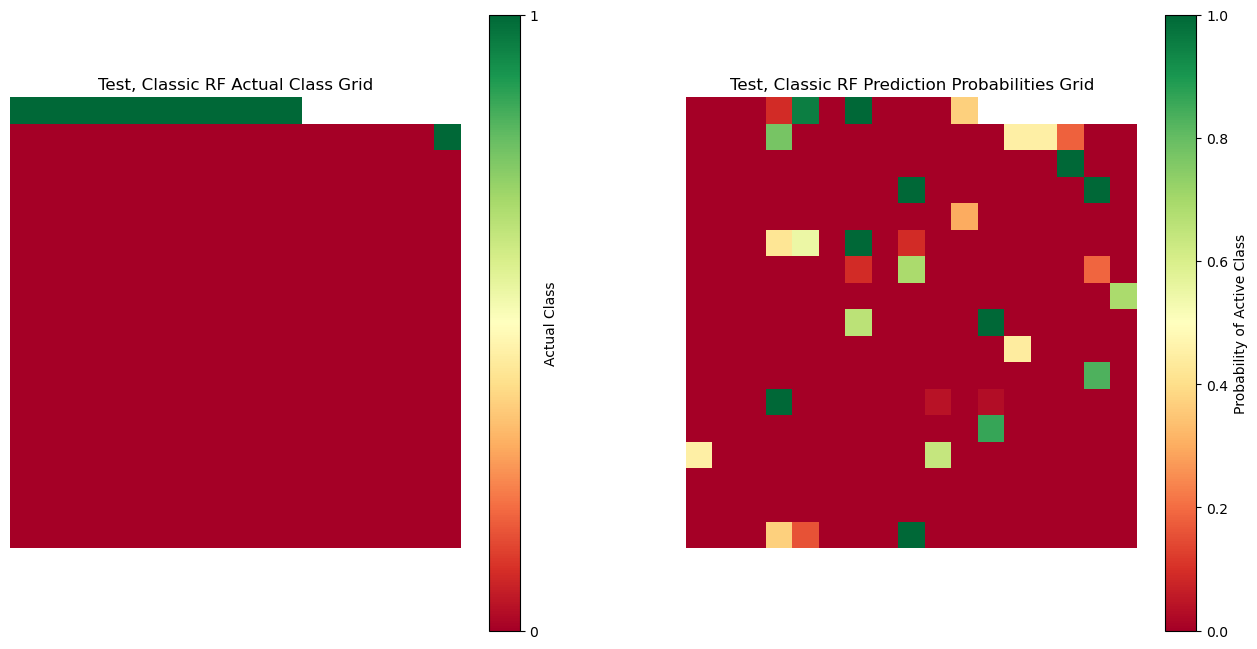

In [93]:
plot_class_and_probability_grids(train_y, prob_train, title_prefix='Train, Classic RF ') # Basic RF 
plot_class_and_probability_grids(test_y, prob_test, title_prefix='Test, Classic RF ') 

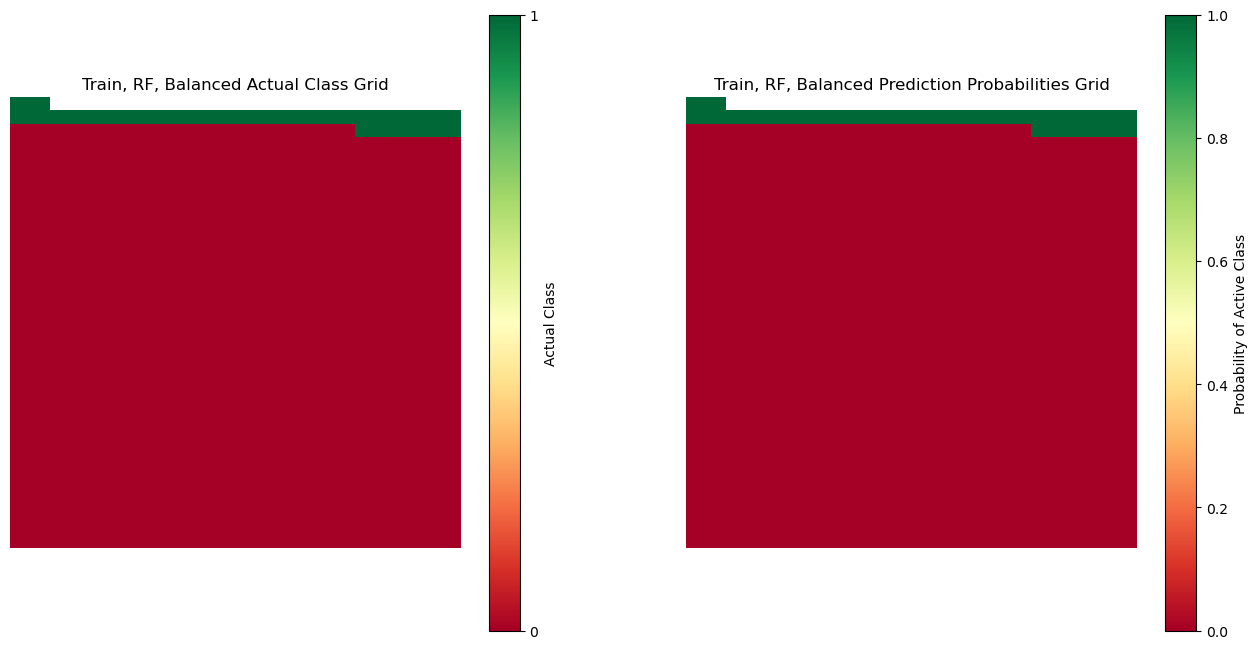

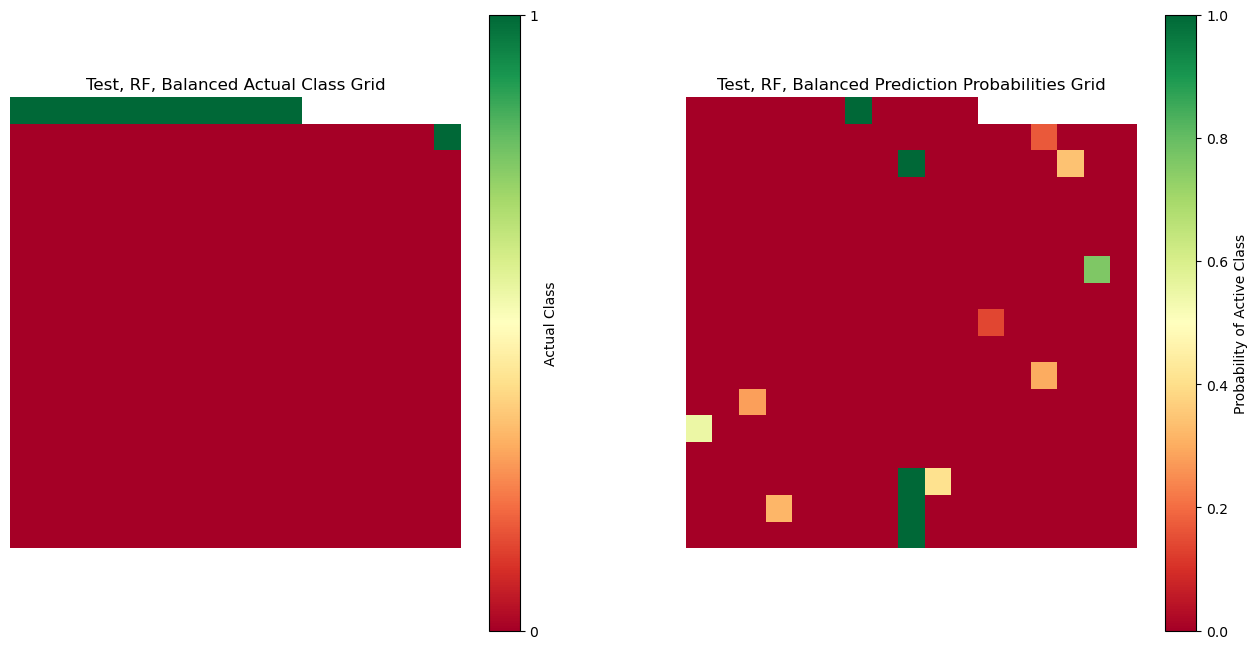

In [74]:
plot_class_and_probability_grids(train_y, prob_train_bal, title_prefix='Train, RF, Balanced ') # Basic RF + balanced class weight 
plot_class_and_probability_grids(test_y, prob_test_bal, title_prefix='Test, RF, Balanced ') 

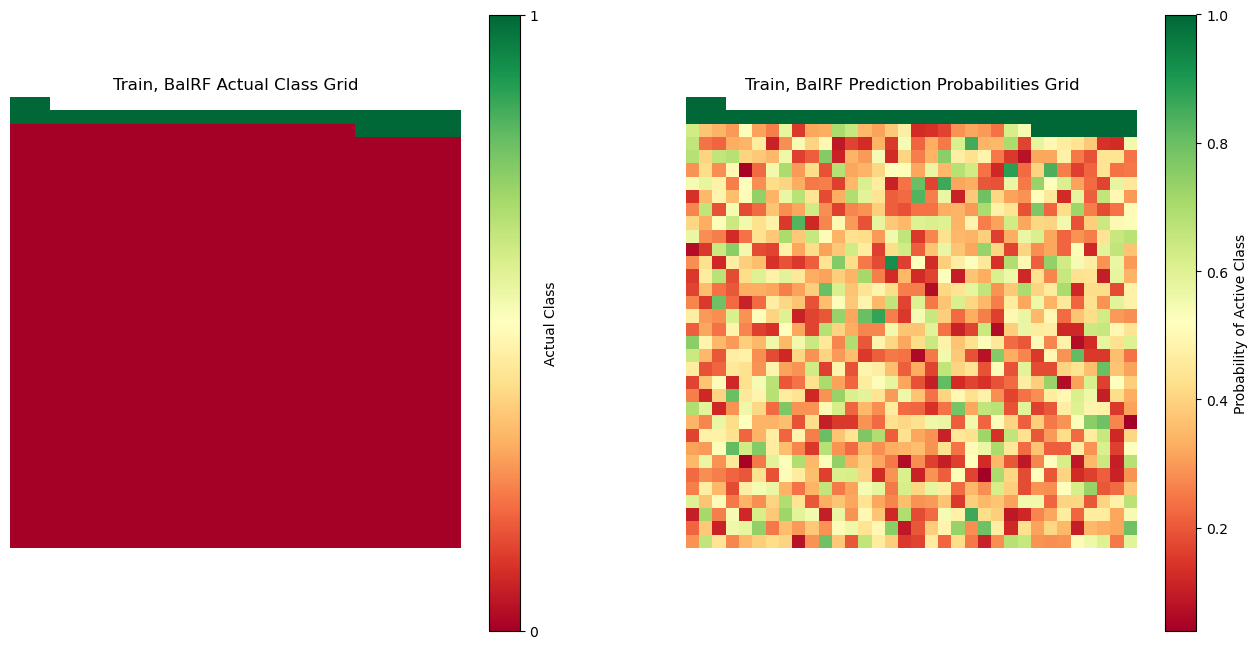

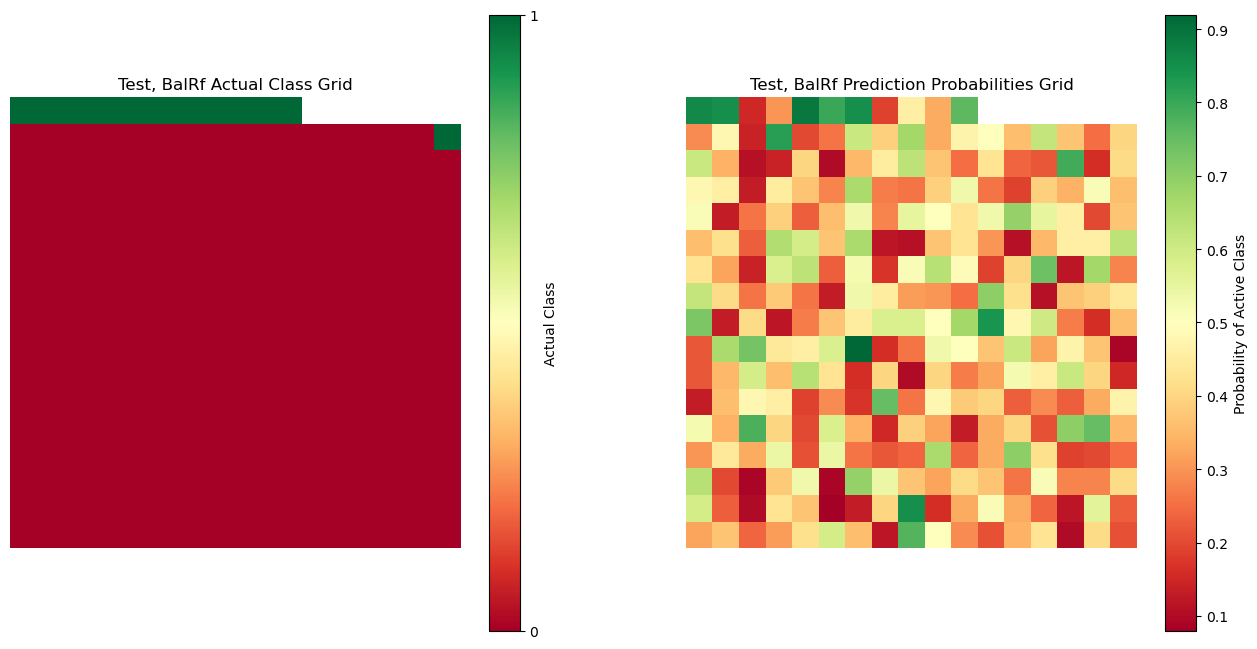

In [75]:
prob_train_rfbal
plot_class_and_probability_grids(train_y, prob_train_rfbal, title_prefix='Train, BalRF ') # Basic RF 
plot_class_and_probability_grids(test_y, prob_test_rfbal, title_prefix='Test, BalRf ') 

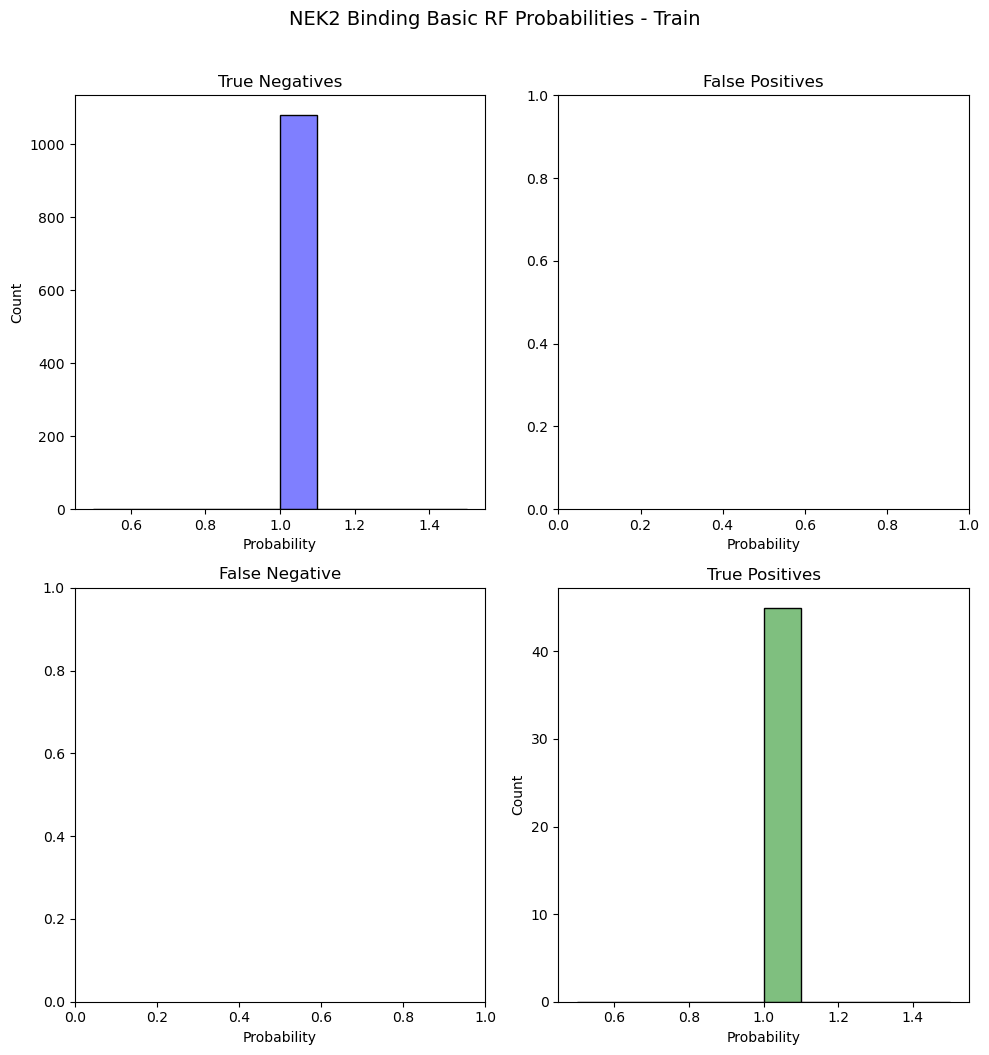

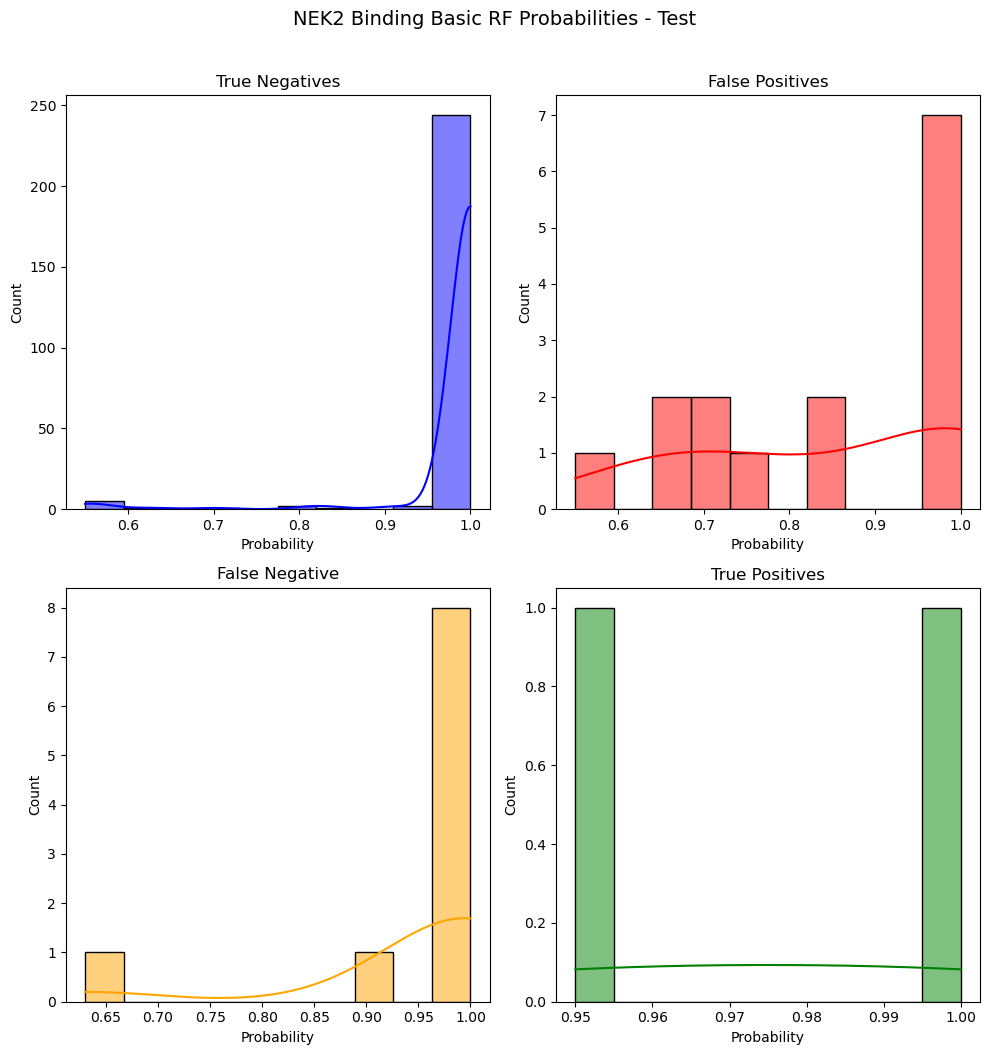

<Figure size 640x480 with 0 Axes>

In [139]:
plot_cm_dist_kde(prob_train, predictions_train,train_y, 'NEK2 Binding Basic RF Probabilities - Train')
plot_cm_dist_kde(prob_test, predictions_test,test_y, 'NEK2 Binding Basic RF Probabilities - Test')
plt.savefig('NEK2_binding_basicrf_prob.png')

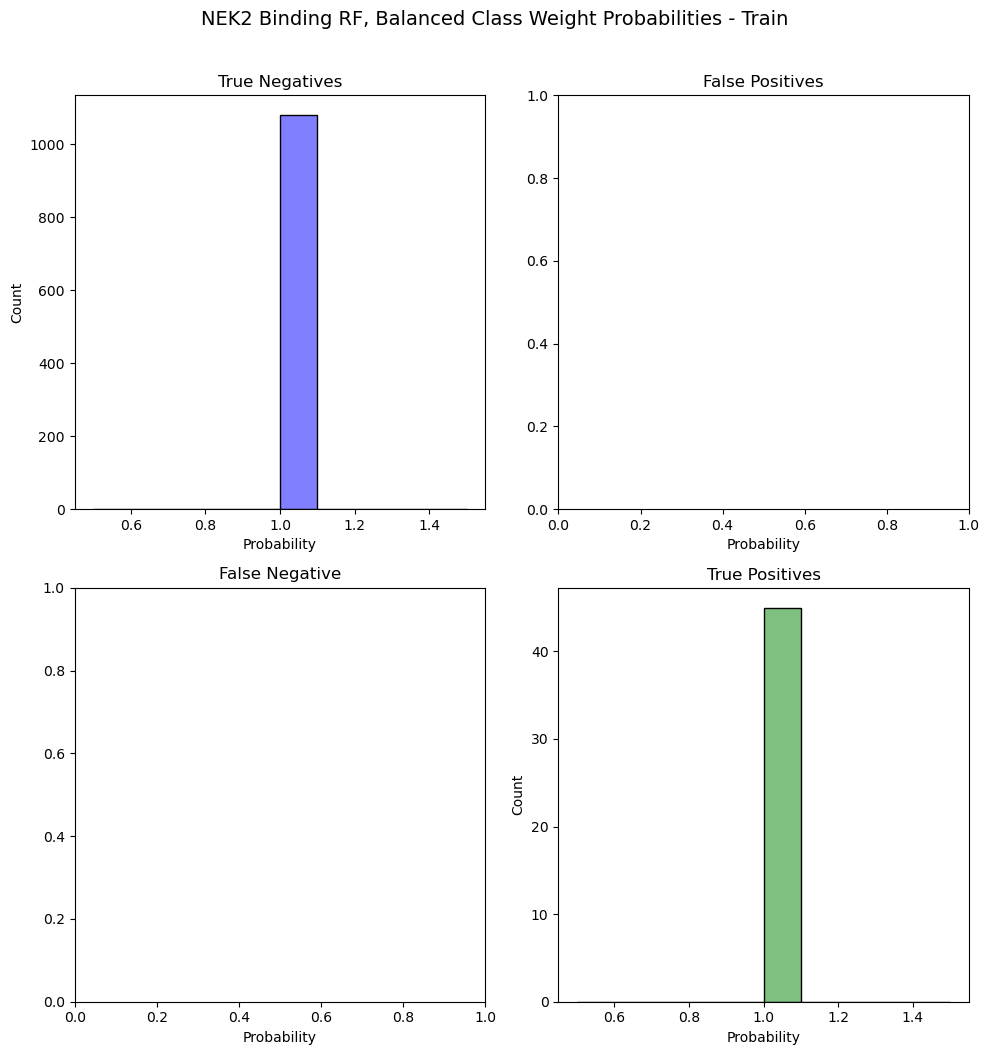

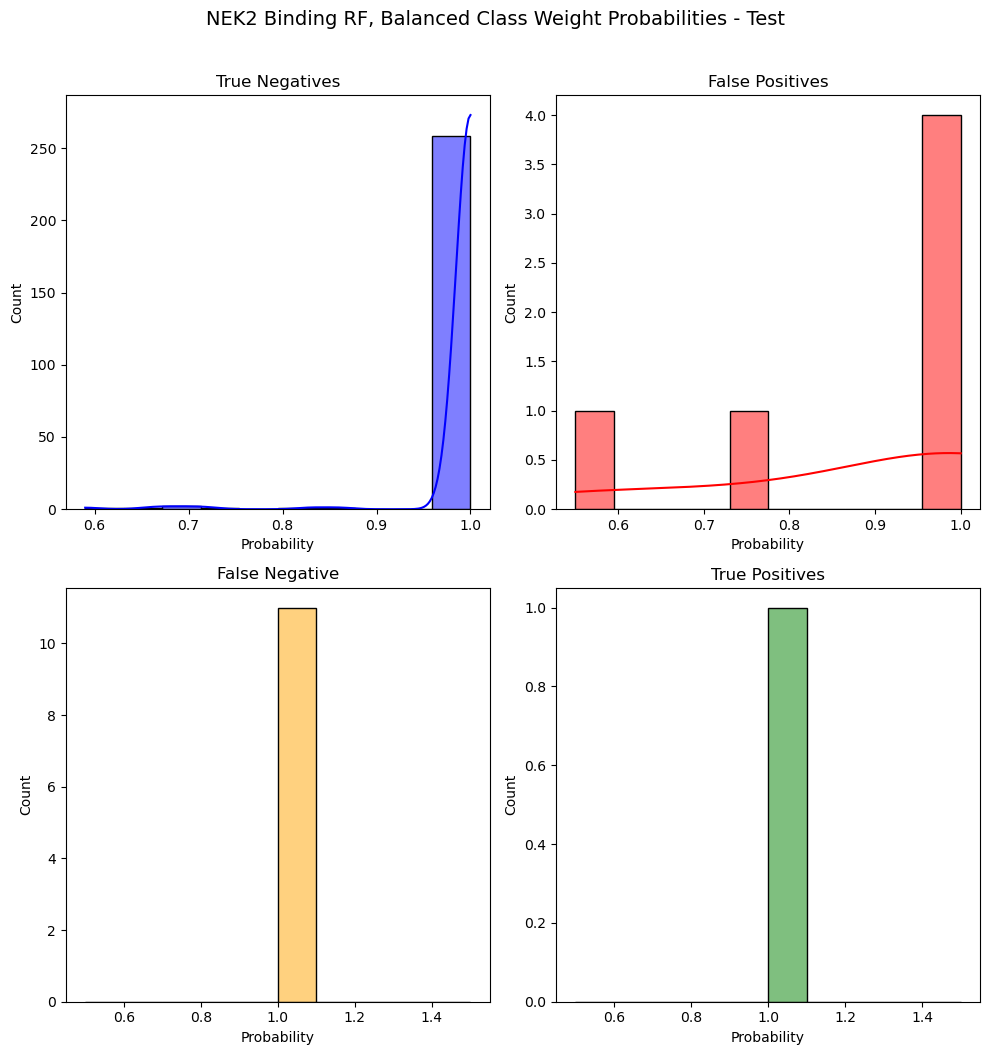

In [82]:
plot_cm_dist_kde(prob_train_bal,predictions_train_bal,train_y, 'NEK2 Binding RF, Balanced Class Weight Probabilities - Train')
plot_cm_dist_kde(prob_test_bal ,predictions_test_bal,test_y, 'NEK2 Binding RF, Balanced Class Weight Probabilities - Test')

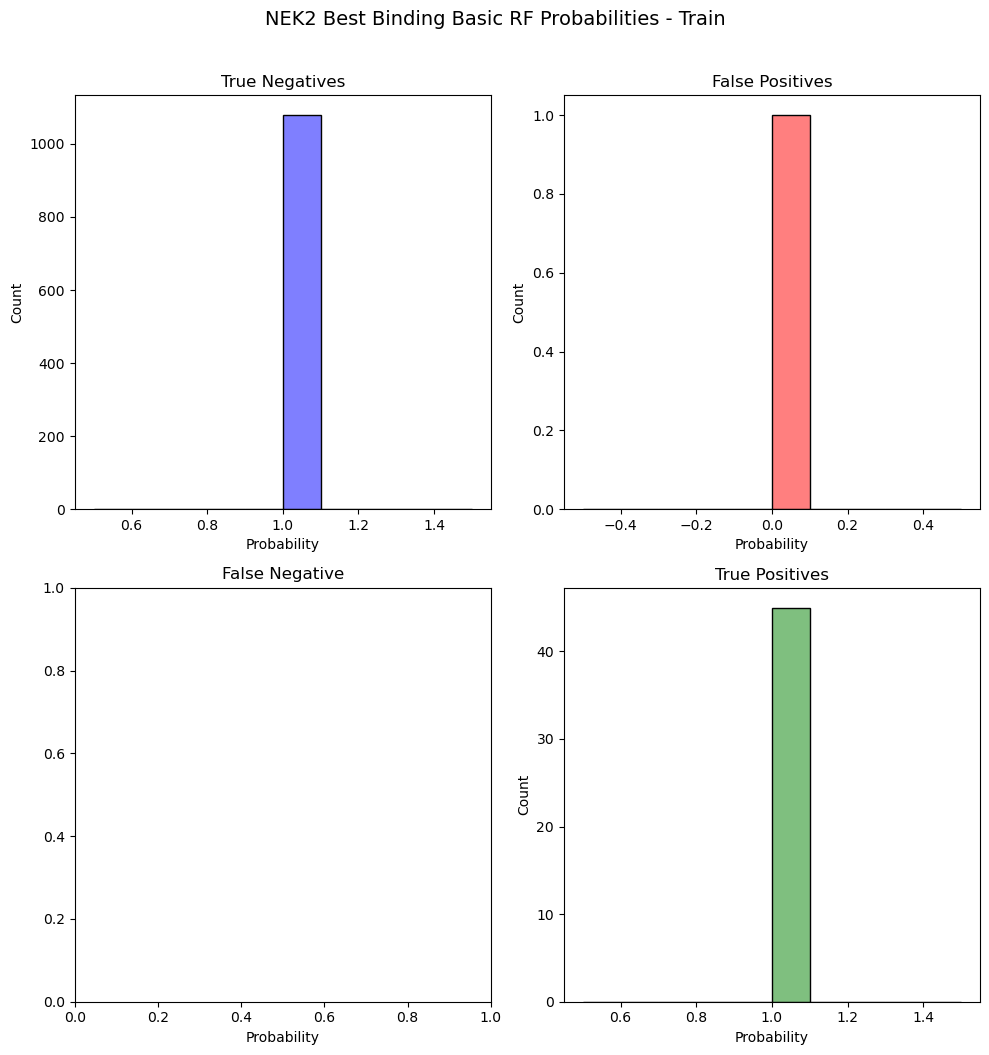

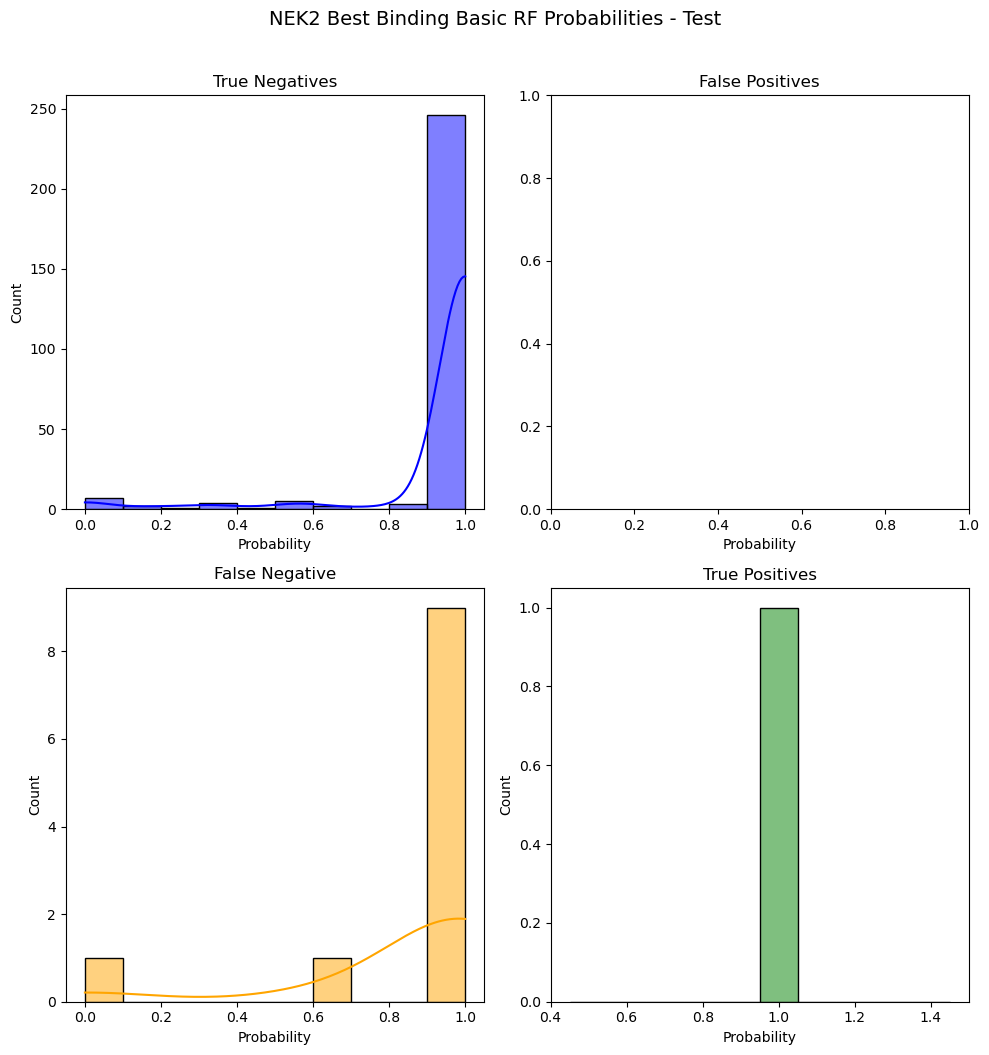

In [94]:

plot_cm_dist_kde(prob_train, pred_train_best,train_y, 'NEK2 Best Binding Basic RF Probabilities - Train')
plot_cm_dist_kde(prob_test, pred_test_best,test_y, 'NEK2 Best Binding Basic RF Probabilities - Test')

In [95]:

pred_train_best
pred_test_best
predictions_train
predictions_test
predictions_train_bal
predictions_test_bal
predictions_train_balrf
predictions_test_balrf

prob_train_best = best_estimator.predict_proba(train_x)
prob_test_best = best_estimator.predict_proba(test_x)
prob_train = rf_basic.predict_proba(train_x)
prob_test = rf_basic.predict_proba(test_x)
prob_train_bal = rf_classweightsbal.predict_proba(train_x) 
prob_test_bal = rf_classweightsbal.predict_proba(test_x) 
prob_train_rfbal = rf_bal.predict_proba(train_x)
prob_test_rfbal = rf_bal.predict_proba(test_x) 



In [137]:
def scatter_prob(true_labels, test_pred, test_prob):
    marker = ['s', 'o', 'D', 'v']
    cm = plt.cm.get_cmap('RdYlBu').reversed() 
    
    fig, ax = plt.subplots(2, 2, figsize=(25, 15))
    true_labels = test_y.numpy()
    prob_pred = np.argmax(prob_test, axis=1) 
    
    # true_pos = np.where((test_pred == 1) & (true_labels == 1))[0] 
    # true_neg = np.where((test_pred == 0) & (true_labels == 0))[0]
    # false_pos = np.where((test_pred == 1) & (true_labels == 0))[0] 
    # false_neg = np.where((test_pred == 0) & (true_labels == 1))[0] 
    
    true_pos = np.where((prob_pred == 1) & (true_labels == 1))[0] 
    true_neg = np.where((prob_pred == 0) & (true_labels == 0))[0]
    false_pos = np.where((prob_pred == 1) & (true_labels == 0))[0] 
    false_neg = np.where((prob_pred == 0) & (true_labels == 1))[0] 
    
    
    sc_tp = ax[1, 1].scatter(true_pos, prob_test[true_pos, 1] - prob_test[true_pos, 0],
                              c=prob_test[true_pos, 1], s=100, cmap=cm, alpha=0.6, marker=marker[0])
    ax[1, 1].set_title('True Positives')
    ax[1, 1].set_xlabel('Data index')
    ax[1, 1].set_ylabel('Actual - Predicted')
    
    
    sc_tn = ax[0, 0].scatter(true_neg, prob_test[true_neg, 1] - prob_test[true_neg, 0],
                              c=prob_test[true_neg, 1], s=100, cmap=cm, alpha=0.6, marker=marker[1])
    ax[0, 0].set_title('True Negatives')
    ax[0, 0].set_xlabel('Data index')
    ax[0, 0].set_ylabel('Actual - Predicted')
    
    
    sc_fp = ax[0, 1].scatter(false_pos, prob_test[false_pos, 1] - prob_test[false_pos, 0],
                              c=prob_test[false_pos, 1], s=100, cmap=cm, alpha=0.6, marker=marker[2])
    ax[0, 1].set_title('False Positives')
    ax[0, 1].set_xlabel('Data index')
    ax[0, 1].set_ylabel('Actual - Predicted')
    
    
    sc_fn = ax[1, 0].scatter(false_neg, prob_test[false_neg, 1] - prob_test[false_neg, 0],
                              c=prob_test[false_neg, 1], s=100, cmap=cm, alpha=0.6, marker=marker[3])
    ax[1, 0].set_title('False Negatives')
    ax[1, 0].set_xlabel('Data index')
    ax[1, 0].set_ylabel('Actual - Predicted')
    
    cbar_tp = fig.colorbar(sc_tp, ax=ax[0, 0], location='right')
    cbar_tp.set_label('Probability', fontsize=16)
    
    cbar_tn = fig.colorbar(sc_tn, ax=ax[0, 1], location='right')
    cbar_tn.set_label('Probability', fontsize=16)
    
    cbar_fp = fig.colorbar(sc_fp, ax=ax[1, 0], location='right')
    cbar_fp.set_label('Probability', fontsize=16)
    
    cbar_fn = fig.colorbar(sc_fn, ax=ax[1, 1], location='right')
    cbar_fn.set_label('Probability', fontsize=16)
    
    plt.tight_layout()
    plt.show()
    # cbar.set_label('Variance', fontsize=16)
    
    plt.tight_layout()
    # plt.savefig(f'nek2_binding_scatter_dist_test.png')
    plt.show()

In [136]:
prob_test.shape

(283, 2)

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_18700/1685939971.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


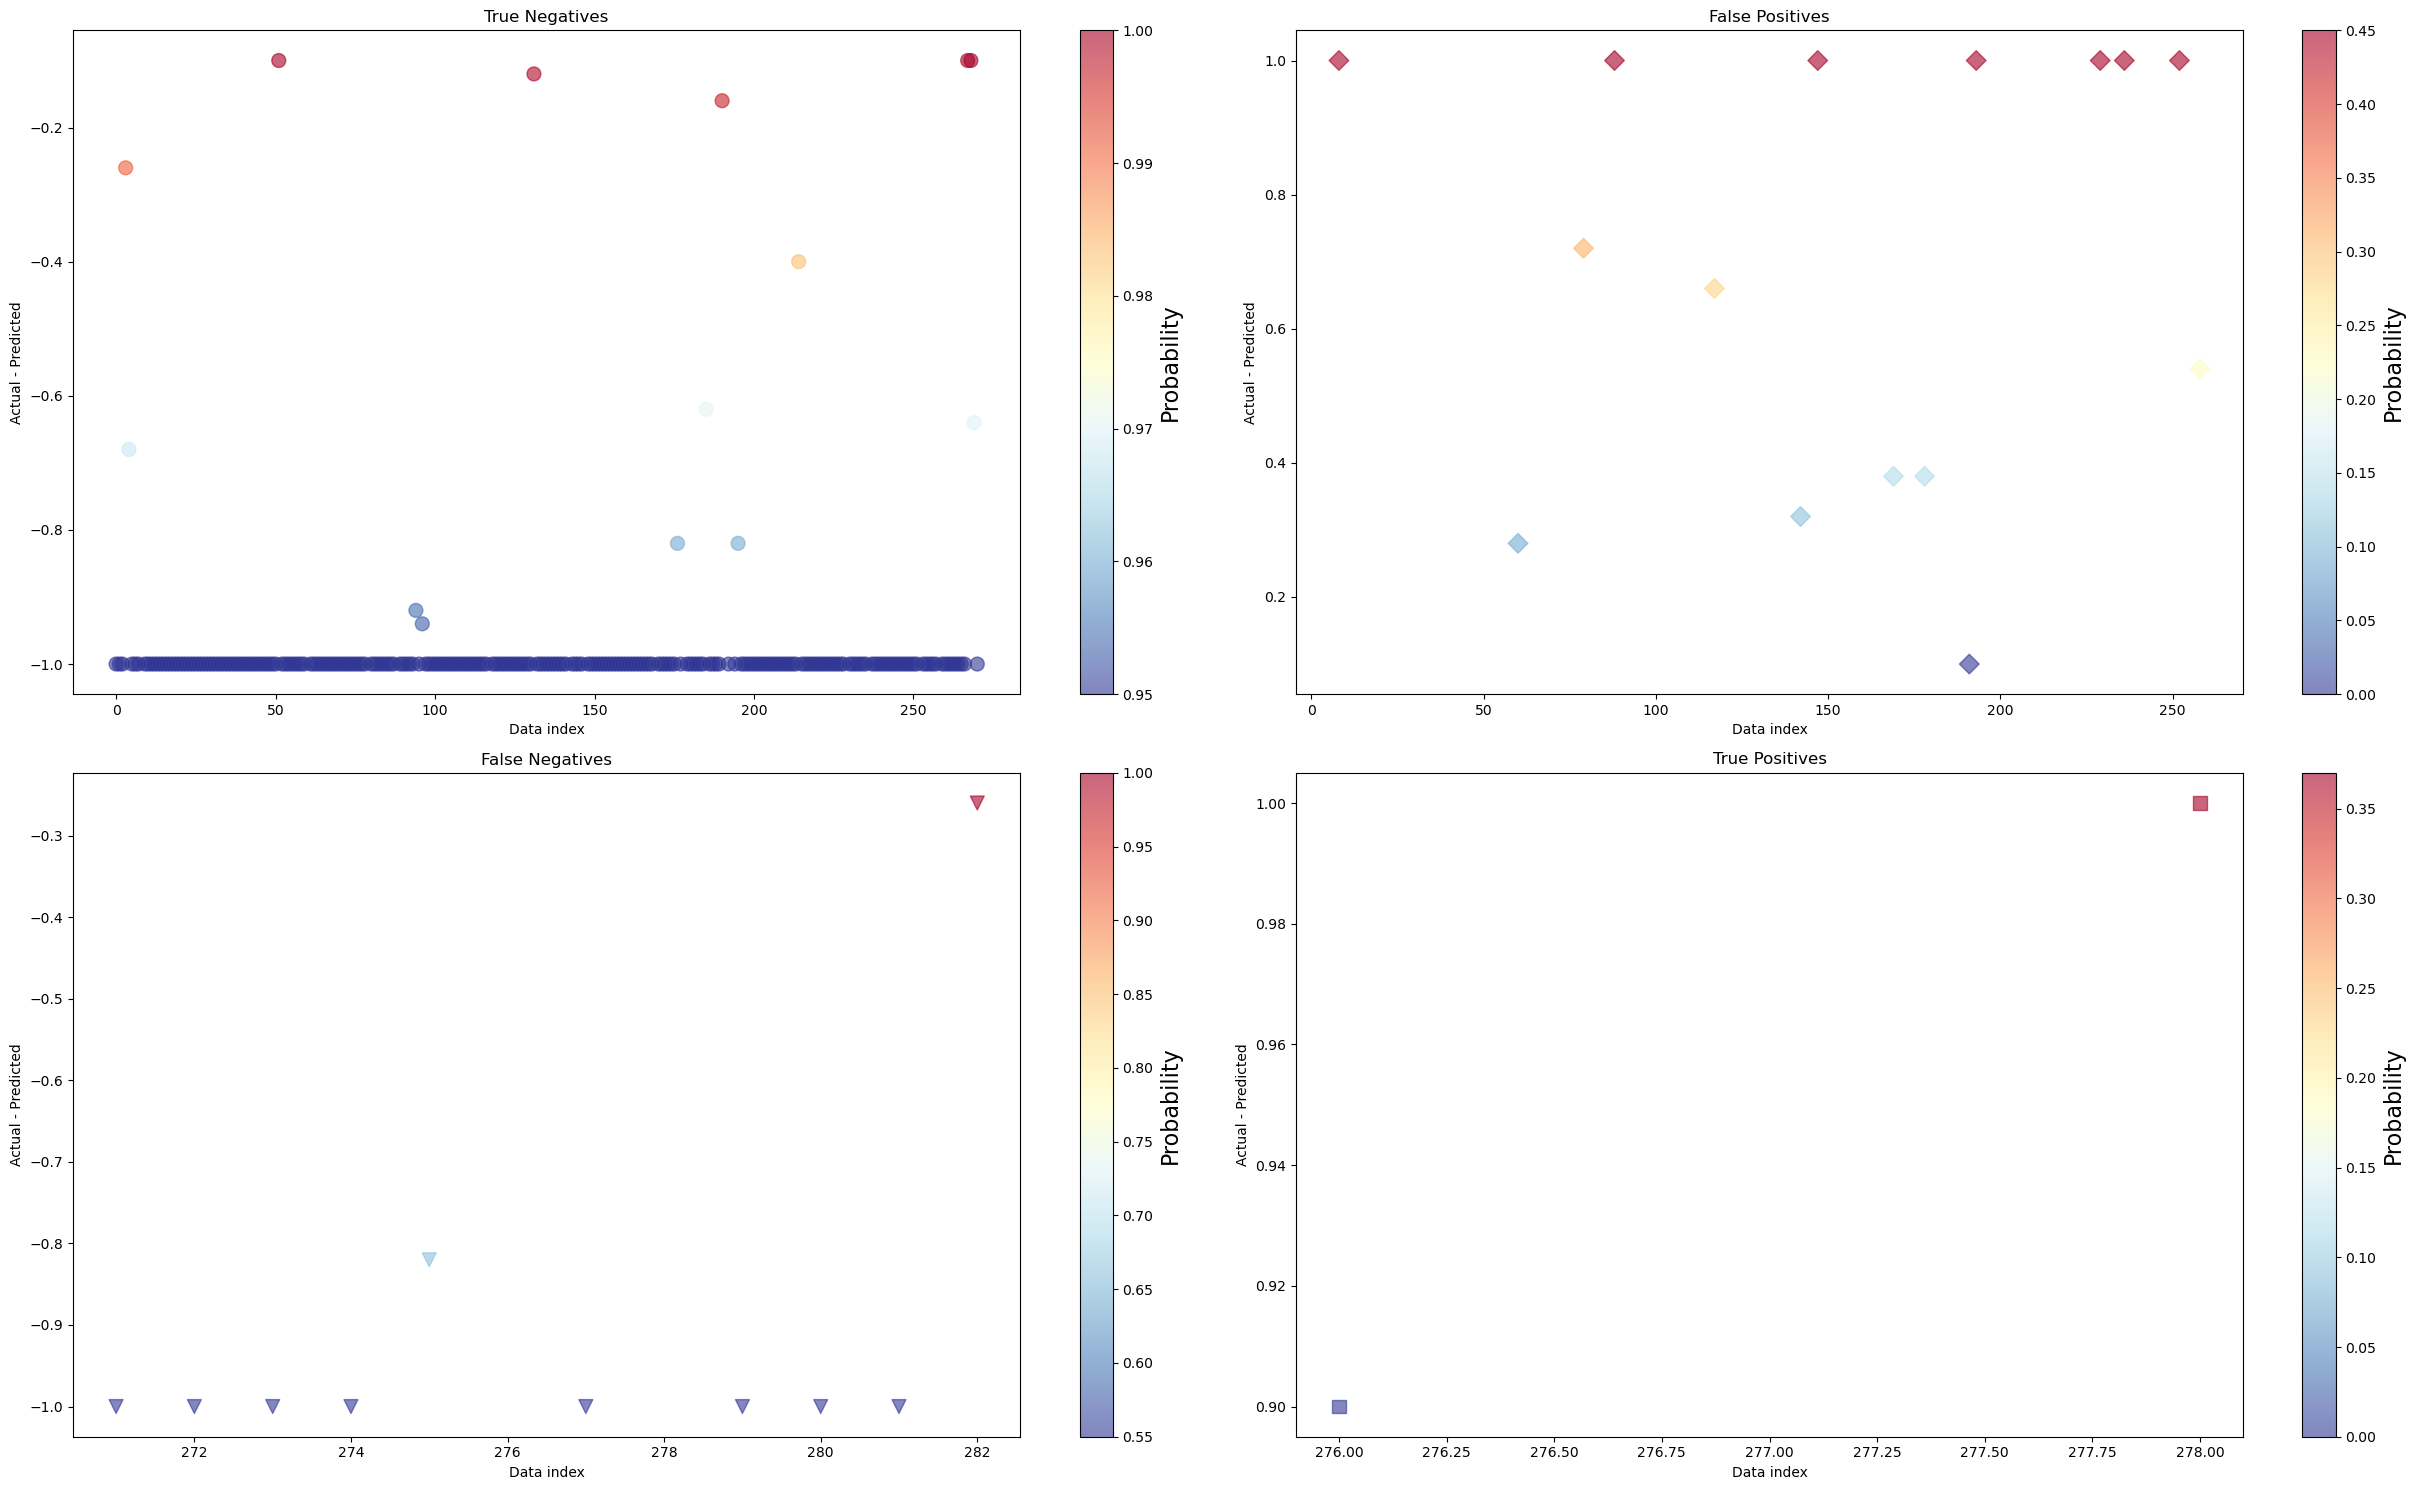

<Figure size 640x480 with 0 Axes>

In [138]:
scatter_prob(test_y, prob_test_best,prob_test )

In [ ]:
plot_cm_dist_kde(prob_train_rfbal,predictions_train_balrf,train_y, 'NEK2 Binding Balanced RF Probabilities - Train')
plot_cm_dist_kde(prob_test_rfbal ,predictions_test_balrf,test_y, 'NEK2 Balanced RF Probabilities - Test')

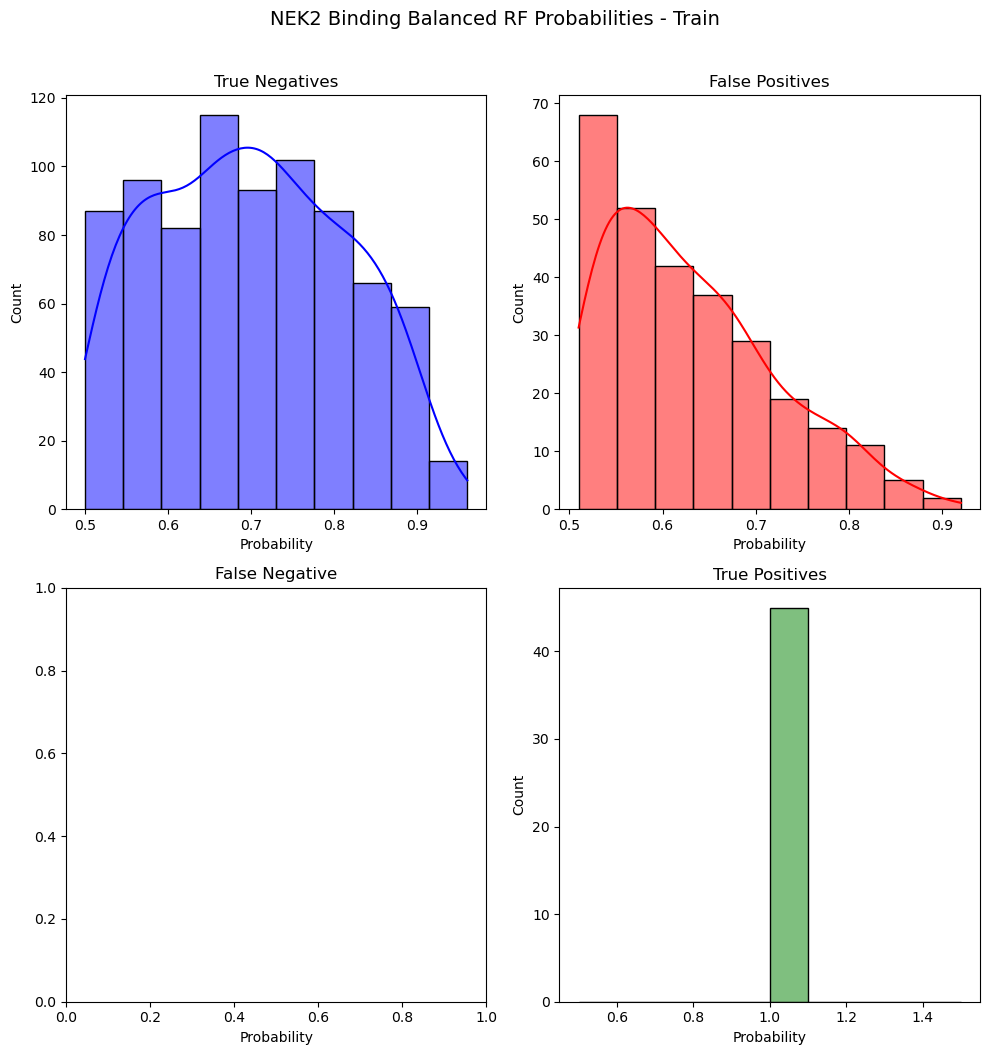

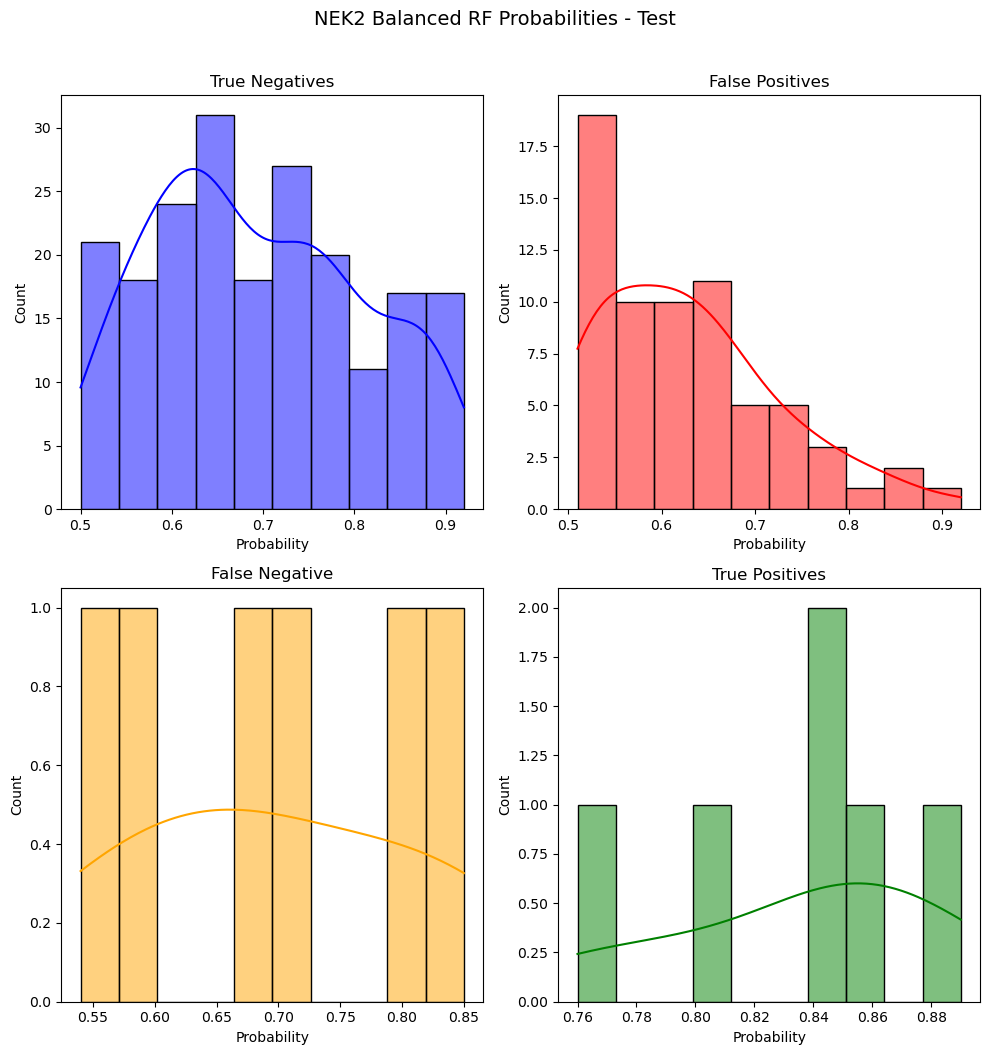

In [83]:
plot_cm_dist_kde(prob_train_rfbal,predictions_train_balrf,train_y, 'NEK2 Binding Balanced RF Probabilities - Train')
plot_cm_dist_kde(prob_test_rfbal ,predictions_test_balrf,test_y, 'NEK2 Balanced RF Probabilities - Test')

In [105]:
# from scipy.stats import randint
# from sklearn.model_selection import RandomizedSearchCV
# param_dist = {
#     'n_estimators': randint(100, 1000),
#     'max_depth': randint(5, 50),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 10),
#     'criterion': ['gini', 'entropy'], 
#     'max_features': ['sqrt', 'log2', None], 
#     'class_weight': ['balanced', None]
# }
# rf_best_basic = RandomForestClassifier() 
# random_search = RandomizedSearchCV(estimator=rf_best_basic , param_distributions=param_dist, n_iter=100, cv=5, random_state=42)
# random_search.fit(train_x, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2af48e5b0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1643f23a0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x162baf4f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x162bafdf0>},
                   random_state=42)

In [ ]:
for param, value in best_params2.items():
    print(f"{param}: {value}")

In [125]:
best_basic_rf = random_search.best_estimator_
best_params_basic = rf_best_basic.get_params()
for param, value in best_params_basic.items():
    print(f"{param}: {value}")
# best_params = random_search.best_params_
# print(best_params)
with open('best_model_randomcv_search_basicrf.pkl', 'wb') as f:
    pickle.dump(best_basic_rf , f)

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


class_weight: balanced
criterion: gini
max_depth: 46
max_features: None
min_samples_leaf: 3
min_samples_split: 13
n_estimators: 666
accuracy best model GridSearch CV train:  0.9991111111111111
accuracy best model GridSearch CV test:  0.9611307420494699


<Axes: title={'center': 'NEK2 Binding Test - Best Estimator'}, xlabel='Predicted label', ylabel='True label'>

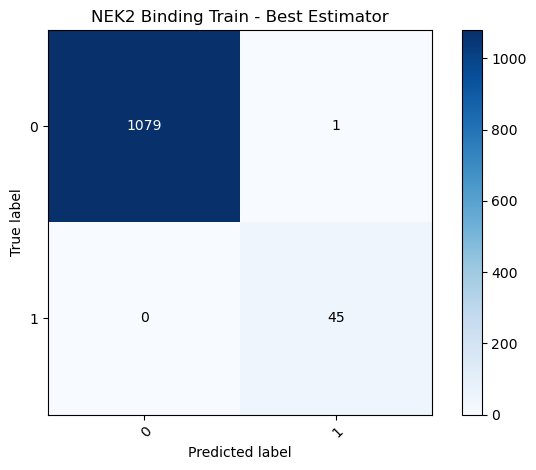

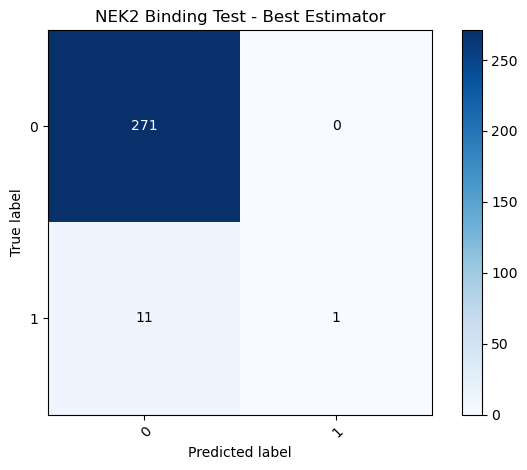

In [124]:
best_params_basic_rf = best_basic_rf.get_params()
for param, value in best_params.items():
    print(f"{param}: {value}")

pred_train_best_basic = best_basic_rf.predict(train_x)
acc_train_best_basic = accuracy_score(train_y, pred_train_best_basic) 
print('accuracy best model GridSearch CV train: ',acc_train_best_basic )
plot_confusion_matrix(train_y.numpy(), pred_train_best_basic, classes, title="NEK2 Binding Train - Best Estimator")


pred_test_best_baisc = best_basic_rf.predict(test_x)
acc_test_best_basic = accuracy_score(test_y, pred_test_best_baisc ) 
print('accuracy best model GridSearch CV test: ',acc_test_best)
plot_confusion_matrix(test_y.numpy(), pred_test_best_baisc , classes, title="NEK2 Binding Test - Best Estimator")

In [112]:
# from scipy.stats import randint
# from sklearn.model_selection import RandomizedSearchCV
# param_dist = {
#     'n_estimators': randint(100, 1000),
#     'max_depth': randint(5, 50),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 10),
#     'criterion': ['gini', 'entropy'], 
#     'max_features': ['sqrt', 'log2', None], 
#     'class_weight': ['balanced', None]
# }
# bal_rf_best = BalancedRandomForestClassifier() 
# random_search2 = RandomizedSearchCV(estimator=bal_rf_best , param_distributions=param_dist, n_iter=100, cv=5, random_state=42)
# random_search2.fit(train_x, train_y)

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

RandomizedSearchCV(cv=5, estimator=BalancedRandomForestClassifier(), n_iter=100,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2aebeff10>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16037b820>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x162ac62b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x160607700>},
                   random_state=42)

In [130]:
bal_rf_best = random_search2.best_estimator_
if hasattr(bal_rf_best, 'feature_importances_'):
    feature_importances = bal_rf_best.feature_importances_
best_param2s = random_search2.best_params_

best_params_bal_rf = bal_rf_best.get_params()
for param, value in best_params_bal_rf.items():
    print(f"{param}: {value}")
print(best_params2)
with open('best_model_randomcv_search_bal_rf.pkl', 'wb') as f:
    pickle.dump(bal_rf_best , f)

bootstrap: warn
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 48
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 3
min_samples_split: 18
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 491
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False
{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': 'warn', 'sampling_strategy': 'warn', 'verbose': 0, 'warm_start': False}


Best BalRandomForest train accuracy: 0.7351111111111112
Best BalRandomForest test accuracy: 0.7455830388692579
accuracy best model GridSearch CV test:  0.7455830388692579


<Axes: title={'center': 'NEK2 Best Bal RF Binding - Train'}, xlabel='Predicted label', ylabel='True label'>

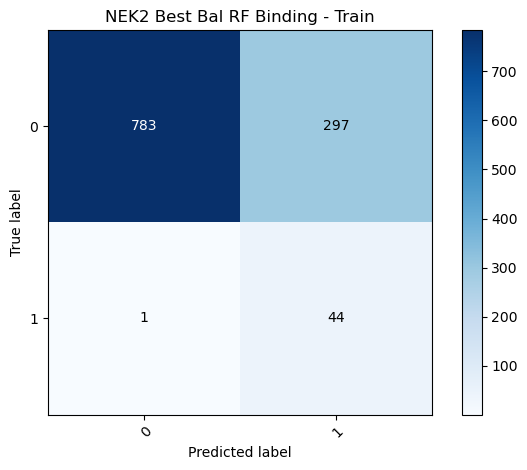

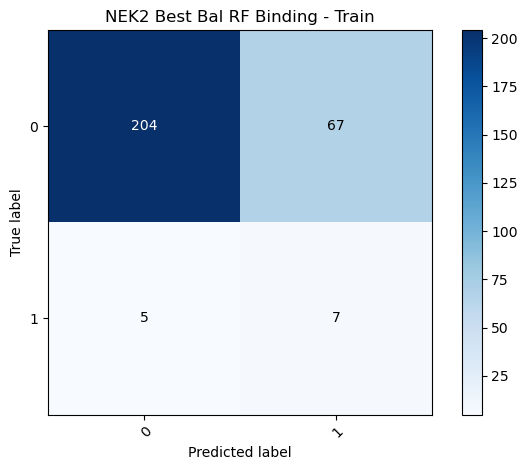

In [129]:

predictions_train_balrf_best = bal_rf_best.predict(train_x)
predictions_test_balrf_best = bal_rf_best.predict(test_x) 
acc_train_balrf_best = accuracy_score(train_y, predictions_train_balrf_best) 
acc_test_balrf_best = accuracy_score(test_y, predictions_test_balrf_best) 
print("Best BalRandomForest train accuracy:", acc_train_balrf_best)
print("Best BalRandomForest test accuracy:",acc_test_balrf_best)

plot_confusion_matrix(train_y.numpy(), predictions_train_balrf_best, classes, title="NEK2 Best Bal RF Binding - Train")


pred_test_best_baisc = best_basic_rf.predict(test_x)
acc_test_best_basic = accuracy_score(test_y, predictions_test_balrf_best) 
print('accuracy best model GridSearch CV test: ',acc_test_balrf_best)
plot_confusion_matrix(test_y.numpy(), predictions_test_balrf_best, classes, title="NEK2 Best Bal RF Binding - Train")

/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/VisUtils.py:126: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob[y_true == 1], label='True Positives', shade=True)
/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/VisUtils.py:127: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob[y_true == 0], label='False Positives', shade=True)


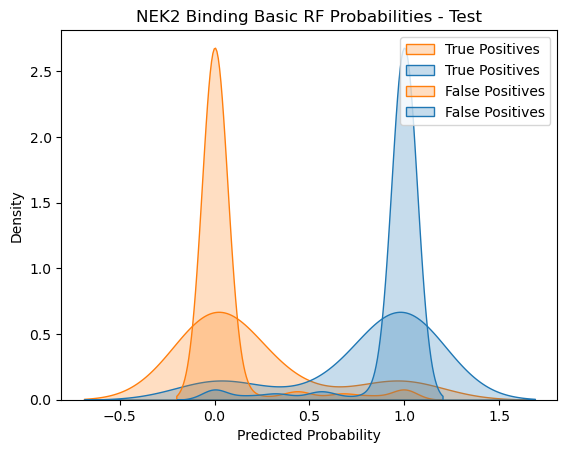

/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/VisUtils.py:126: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob[y_true == 1], label='True Positives', shade=True)
/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/VisUtils.py:127: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob[y_true == 0], label='False Positives', shade=True)


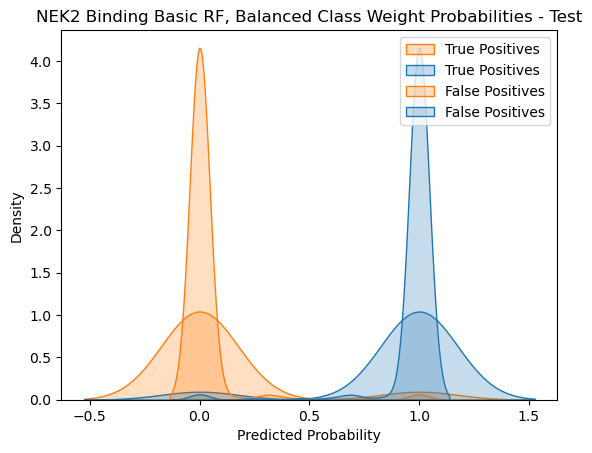

/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/VisUtils.py:126: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob[y_true == 1], label='True Positives', shade=True)
/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/VisUtils.py:127: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_prob[y_true == 0], label='False Positives', shade=True)


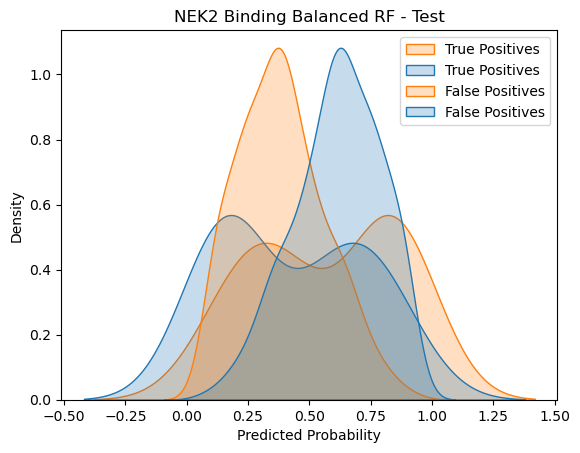

In [66]:
# plot_cm_dist_kde(train_y, prob_train, title="NEK2 Binding Basic RF Probabilities - Train")
plot_cm_dist_kde(test_y,prob_test, title="NEK2 Binding Basic RF Probabilities - Test")


# plot_cm_dist_kde(train_y, prob_train_bal, title="NEK2 Binding Basic RF, Balanced Class Weight Probabilities - Train")
plot_cm_dist_kde(test_y,prob_teset_bal, title="NEK2 Binding Basic RF, Balanced Class Weight Probabilities - Test")

plot_cm_dist_kde(test_y,prob_test_rfbal, title="NEK2 Binding Balanced RF - Test")

In [19]:
all_fold_df = pd.read_csv(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')
smile_prop_train = all_fold_df[all_fold_df['fold'] != 'fold5'].drop(columns=['fold'])
smile_prop_test = all_fold_df[all_fold_df['fold'] == 'fold5'].drop(columns=['fold'])

mol_train = []
for i in smile_prop_train.index:
    m = Chem.MolFromSmiles(smile_prop_train.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_train.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_train.loc[i, 'active']))
        mol_train.append(utils.normalize(m))

mol_test = []
for i in smile_prop_test.index:
    m = Chem.MolFromSmiles(smile_prop_test.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_test.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_test.loc[i, 'active']))
        mol_test.append(utils.normalize(m))


[01:24:10] Initializing MetalDisconnector
[01:24:10] Running MetalDisconnector
[01:24:10] Initializing Normalizer
[01:24:10] Running Normalizer
[01:24:10] Running LargestFragmentChooser
[01:24:10] Running Uncharger
[01:24:10] Initializing MetalDisconnector
[01:24:10] Running MetalDisconnector
[01:24:10] Initializing Normalizer
[01:24:10] Running Normalizer
[01:24:10] Initializing MetalDisconnector
[01:24:10] Running MetalDisconnector
[01:24:10] Initializing Normalizer
[01:24:10] Running Normalizer
[01:24:10] Running LargestFragmentChooser
[01:24:10] Running Uncharger
[01:24:10] Initializing MetalDisconnector
[01:24:10] Running MetalDisconnector
[01:24:10] Initializing Normalizer
[01:24:10] Running Normalizer
[01:24:10] Initializing MetalDisconnector
[01:24:10] Running MetalDisconnector
[01:24:10] Initializing Normalizer
[01:24:10] Running Normalizer
[01:24:10] Running LargestFragmentChooser
[01:24:10] Running Uncharger
[01:24:10] Initializing MetalDisconnector
[01:24:10] Running MetalD

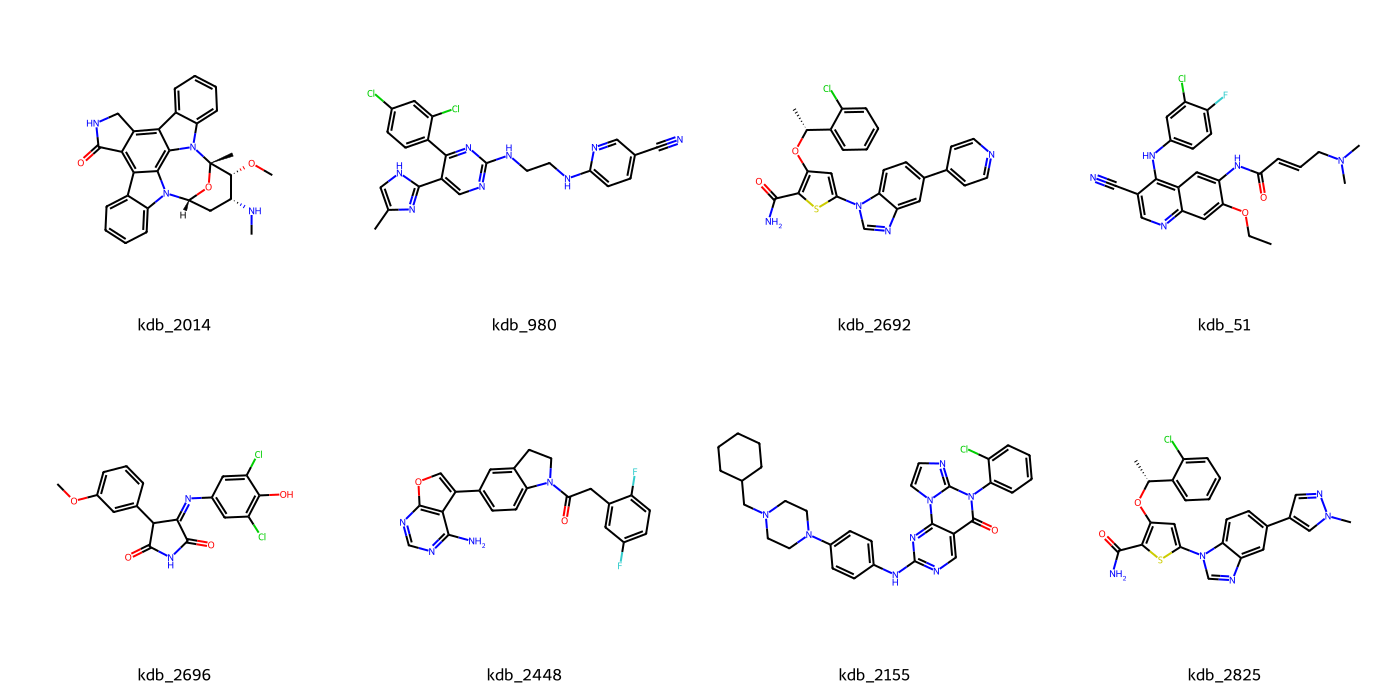

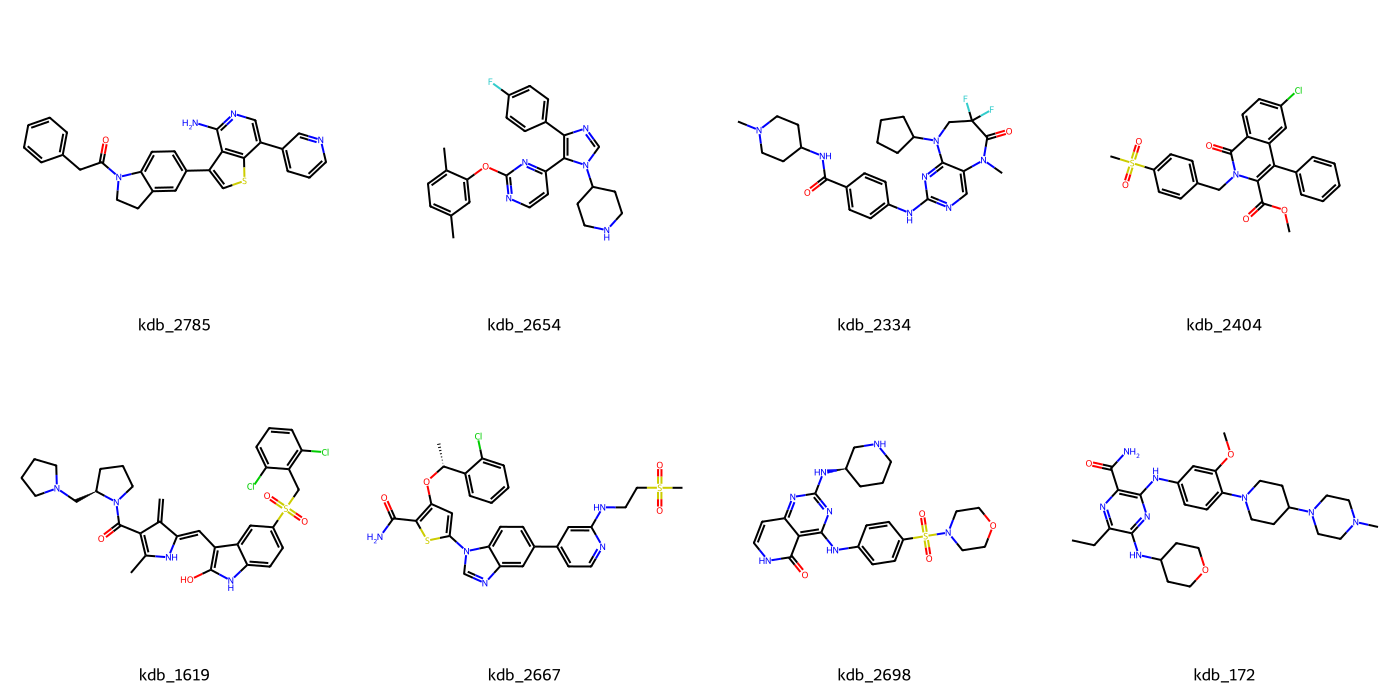

In [84]:
from PIL import Image
active_train = []

for m in mol_train:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_train.append(m)

# active_train_mols= Draw.MolsToGridImage(active_train[:8],molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_train[:8]])
display(Draw.MolsToGridImage(active_train[:8],molsPerRow=4,subImgSize=(350,350),legends=[x.GetProp("_Name") for x in active_train[:12]]))

active_test = []
for m in mol_test:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_test.append(m)

# active_test_mols = Draw.MolsToGridImage(active_test[:8],molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_test[:8]])
display(Draw.MolsToGridImage(active_test[:8],molsPerRow=4,subImgSize=(350,350),legends=[x.GetProp("_Name") for x in active_test[:12]]))


In [34]:
X_existing_train = smile_prop_train.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
X_existing_test = smile_prop_test.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
y_train = smile_prop_train['active']
y_test = smile_prop_test['active']

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_train]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_train = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_train.append(arr)

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_test]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_test = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_test.append(arr)


In [35]:
# output_file1 = os.path.join(split_path, 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced_train.sdf')
# output_file2 = os.path.join(split_path, 'data/NEK2/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced_test.sdf')
with Chem.SDWriter(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced_train.sdf') as writer:
    for m in mol_train:
        writer.write(m)

with Chem.SDWriter(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced_test.sdf') as writer:
    for m in mol_test:
        writer.write(m)

Accuracy: 1.0
Accuracy test: 0.9466192170818505


<Axes: title={'center': 'NEK2 Binding Train - AG'}, xlabel='Predicted label', ylabel='True label'>

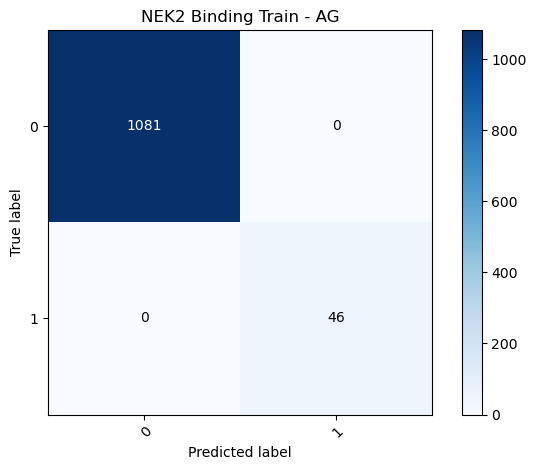

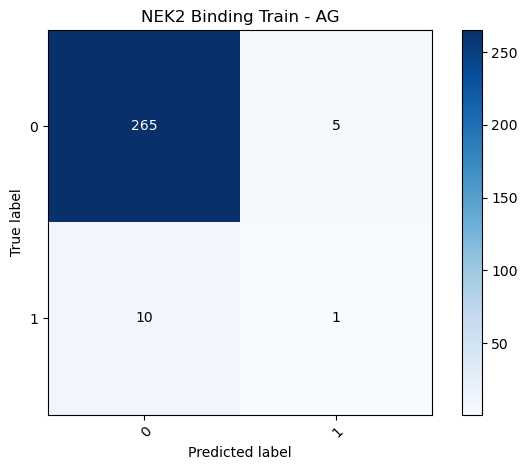

In [45]:
# accuracy, precision, recall, conf_matrix = rf_model(X_existing_train, y_train, X_existing_test, y_test)
rf_ag= rf_model(X_existing_train, y_train, {}) 
predictions_train_ag = rf_ag.predict(X_existing_train)
predictions_test_ag = rf_ag.predict(X_existing_test)
accuracy_train_ag = accuracy_score(y_train, predictions_train_ag) 
accuracy_test_ag = accuracy_score( y_test, predictions_test_ag) 
print("Accuracy:", accuracy_train_ag)
print("Accuracy test:", accuracy_test_ag)

plot_confusion_matrix(y_train, predictions_train_ag, classes, title="NEK2 Binding Train - AG")
plot_confusion_matrix(y_test, predictions_test_ag, classes, title="NEK2 Binding Train - AG")

Accuracy: 0.9982253771073647
Accuracy test: 0.9466192170818505


<Axes: title={'center': 'NEK2 Binding Train - Morgan fingerprints'}, xlabel='Predicted label', ylabel='True label'>

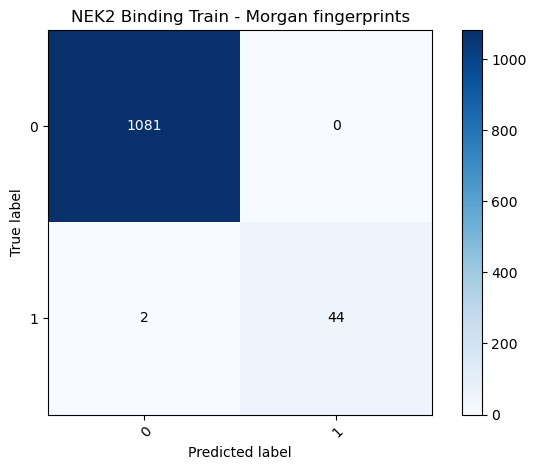

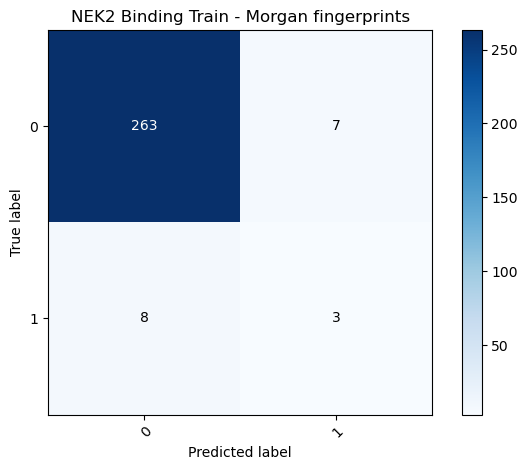

In [86]:
# accuracy, precision, recall, conf_matrix = rf_model(X_existing_train, y_train, X_existing_test, y_test)
rf_morgan= rf_model(X_morgan_train, y_train, {}) 
predictions_train_morgan = rf_morgan.predict(X_morgan_train)
predictions_test_morgan = rf_morgan.predict(X_morgan_test)
accuracy_train_morgan = accuracy_score(y_train, predictions_train_morgan) 
accuracy_test_morgan = accuracy_score( y_test, predictions_test_morgan ) 
print("Accuracy:", accuracy_train_morgan)
print("Accuracy test:", accuracy_test_morgan)

plot_confusion_matrix(y_train, predictions_train_morgan, classes, title="NEK2 Binding Train - Morgan fingerprints")
plot_confusion_matrix(y_test, predictions_test_morgan, classes, title="NEK2 Binding Train - Morgan fingerprints")


# accuracy, precision, recall, conf_matrix = rf_model(X_morgan_train, y_train, X_morgan_test, y_test)

# print("Accuracy:", accuracy)
# plot_confusion_matrix(conf_matrix, ["0", "1"]);

In [89]:
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_existing_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_os_train, y_os_train, {})

# print("Accuracy:", accuracy)
# plot_confusion_matrix(conf_matrix, ["0", "1"]);

ValueError: too many values to unpack (expected 4)